<h1>
      <h4>
          <p style="font-size:36pt"> -- Heart disease predictions -- </p>
          <p style="font-size:24pt"> Reproducing existing research on an extended set of data</p>
      </h4>
</h1>

# Table of Contents
* [1. Introduction and problem framing](#1.-Introduction-and-problem-framing)
* [2. Set-up](#2.-Set-up)
* [3. Data extraction](#3.-Data-extraction)
* [4. Exploratory data analysis](#4.-Exploratory-data-analysis)
* [5. Data preparation](#5.-Data-preparation)
* [6. Model selection and training](#6.-Model-selection)
* [7. Model fine-tuning](#7.-Model-fine-tuning)
* [8. Conclusion](#8.-Conclusion)
* [9. References](#9.-References)
* [10. Appendix](#10.-Appendix)

Notebook link:
https://github.com/Averdier-20/Predictive_assignment

# 1. Introduction and problem framing

As of today, Coronavirus has caused more than 2.5 million deaths. But another disease is still killing more than three times this amount of people almost every year, with 8.9 million deaths as of 2019 (World Health Organisation, 2020), and is yet far from getting the same attention. Its coronary heart disease.

Predicting coronary heart disease has been a great challenge for healthcare practitioners for many years, and now machine learning experts. A significant amount of litterature exist on this topic ((Tougui, Jilbab and El Mhamdi 2020) and (Rani, P. et al. 2021)), and researchers have mainly used one particular data set to evaluate their model and predictions, which is the Cleveland data set, results from clinical and noninvasive test results of 303 patients under-going angiography at the Cleveland Clink in Cleveland, Ohio in 1988.

We aim to reproduce results from the available litterature on a larger set of clinical results extending the number of diagnosis based on UCI data, and evaluate the performance of our selected model not only based on accuracy but also using our own performance metric with an emphasis on recall due to the nature of the problem.

# 2. Set-up

In [ ]:
#!pip install missingno
#!pip install xgboost

In [1]:
# Common imports
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 


# to make this notebook's output stable across runs
seed_value = 42
np.random.seed(seed_value)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Set colors for consistency
color_main = '#8ECAE6'
color_healthy = '#023047'
color_sick = '#FB8500'
color_tuning = '#219EBC'
color_validation = '#FFB703'

# 3. Data import

The data has been downloaded from UCI repository  (UCI Machine Learning Repository: Heart Disease Data Set, 2021) and refined across 4 csv files for the different locations. The description of the different features is available in Appendix 1.

In [2]:
## Import the 4 different data files from the files taken from UCI repository

# Columns labels renammed based on the file 'heart-disease.names' available within the UCI repository
column_labels = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 
                 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate', 'exercise_induced_angina', 'oldpeak',
                 'slope', 'colored_vessels', 'thal', 'heart_disease']

# Files location
file_loc = 'C:\\Users\\user\\Documents_C\\Python\\Jupyter\\04. Predictive analytics\Individual assignment\\Source_data\\'

# Import data for each data set
data_cleveland = pd.read_csv((file_loc +'processed.cleveland.data'), names = column_labels)

data_hungarian = pd.read_csv((file_loc + 'processed.hungarian.data'), names = column_labels)

data_switzerland = pd.read_csv((file_loc + 'processed.switzerland.data'), names = column_labels)

data_va = pd.read_csv((file_loc + 'processed.va.data'), names = column_labels)

# Import data within single dataframe
df = pd.concat([data_cleveland, data_hungarian, data_switzerland, data_va])
df_original = df.reset_index()
df = df.sample(frac=1).reset_index(drop=True)

# 4. Exploratory data analysis

We start by having a quick look at the overall dataset and perfom some data cleaning manipulation to enable further exploration.

In [3]:
df

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_induced_angina,oldpeak,slope,colored_vessels,thal,heart_disease
0,36.0,1.0,2.0,120,166,0,0,180,0,0,?,?,?,0
1,45.0,1.0,2.0,140,224,1,0,122,0,0,?,?,?,0
2,48.0,1.0,4.0,160,329,0,0,92,1,1.5,2,?,?,1
3,59.0,1.0,4.0,164,176,1,2,90,0,1,2,2.0,6.0,3
4,40.0,0.0,4.0,150,392,0,0,130,0,2,2,?,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,59.0,1.0,4.0,140,177,0,0,162,1,0,1,1.0,7.0,2
916,61.0,1.0,4.0,140,207,0,2,138,1,1.9,1,1.0,7.0,1
917,75.0,1.0,4.0,160,310,1,0,112,1,2,3,?,7,0
918,53.0,0.0,2.0,140,216,0,0,142,1,2,2,?,?,0


We replace the 'heart disease' column with binary values for our labels, indicating the presence or absence of heart disease, perform a first round of data cleaning, and observe the number of missing values for the different features.

In [4]:
# Transforming the 'heart_disease' column into binary labels
df['label'] = np.where(df['heart_disease']!= 0, 1, 0)
df = df.drop("heart_disease", axis=1)

In [5]:
# Replace '?' string values by nan.values
column_labels = df.columns
for i in column_labels:
    df[i] = df[i].apply(lambda x: np.nan if x == '?' else x)

In [6]:
## Function to get the index positions of for each columns within a list

def col_positions(list_col):
    col_index = []
    for i in list_col:
        pos = df.columns.get_loc(i)
        col_index.append(pos)

    return col_index

In [7]:
## Function to label columns based on number of missing value and extract column related names for each category

# Function to define treshold for the different categories
def missing_value_label(x):
    if x >= 50:
        return 'red'
    elif 50 >= x > 0.1:
        return 'orange'
    else:
        return 'green'

# Function to create dataframes of column names and category
def missing_value_df(df):
    missing_value_per_columns = pd.DataFrame(df.isna().mean().round(4) * 100)
    missing_value_per_columns['msno_label'] = missing_value_per_columns[0].apply(missing_value_label)
    return missing_value_per_columns

# Function to obtain column names as list for specified category
def extract_col_cat(df_col, category):
    for i in np.where(df_col['msno_label'] == category):
        columns_names = df_col.index[i].tolist()
    return columns_names

In [8]:
## Function to plot missing values

import matplotlib.patches as mpatches

def missing_val_plot(df, title):
    # Plot the number of missing values per attributes
    ax = msno.bar(df)

    #Formatting
    plt.title(title, fontweight = 'bold', fontsize = 18, pad = 80)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linewidth=0.3)

    # Set color for specific columns
    df_column_category = missing_value_df(df)

    list_col_red = col_positions(extract_col_cat(df_column_category, 'red'))
    for i in list_col_red:
        ax.patches[i].set_facecolor('#aa3333')

    list_col_orange = col_positions(extract_col_cat(df_column_category, 'orange'))
    for i in list_col_orange:
        ax.patches[i].set_facecolor('#face6e')

    list_col_gray = col_positions(extract_col_cat(df_column_category, 'green'))
    for i in list_col_gray:
        ax.patches[i].set_facecolor('#ebebeb')

    # Create patches for legend
    gray_patch = mpatches.Patch(color='#ebebeb', label='Low')
    orange_patch = mpatches.Patch(color='#face6e', label='Medium')
    red_patch = mpatches.Patch(color='#aa3333', label='High')

    #Conditional formating on patches
    handles_patch = []
    if list_col_gray:
        handles_patch.append(gray_patch)
    if list_col_orange:
        handles_patch.append(orange_patch)
    if list_col_red:
        handles_patch.append(red_patch)

    # Legend formatting
    ax.legend(loc = 1,
              handles= handles_patch,
              fontsize = 18,
              bbox_to_anchor = (0,-0.1,1.05,1),  
              borderaxespad=2, 
              bbox_transform = plt.gcf().transFigure)

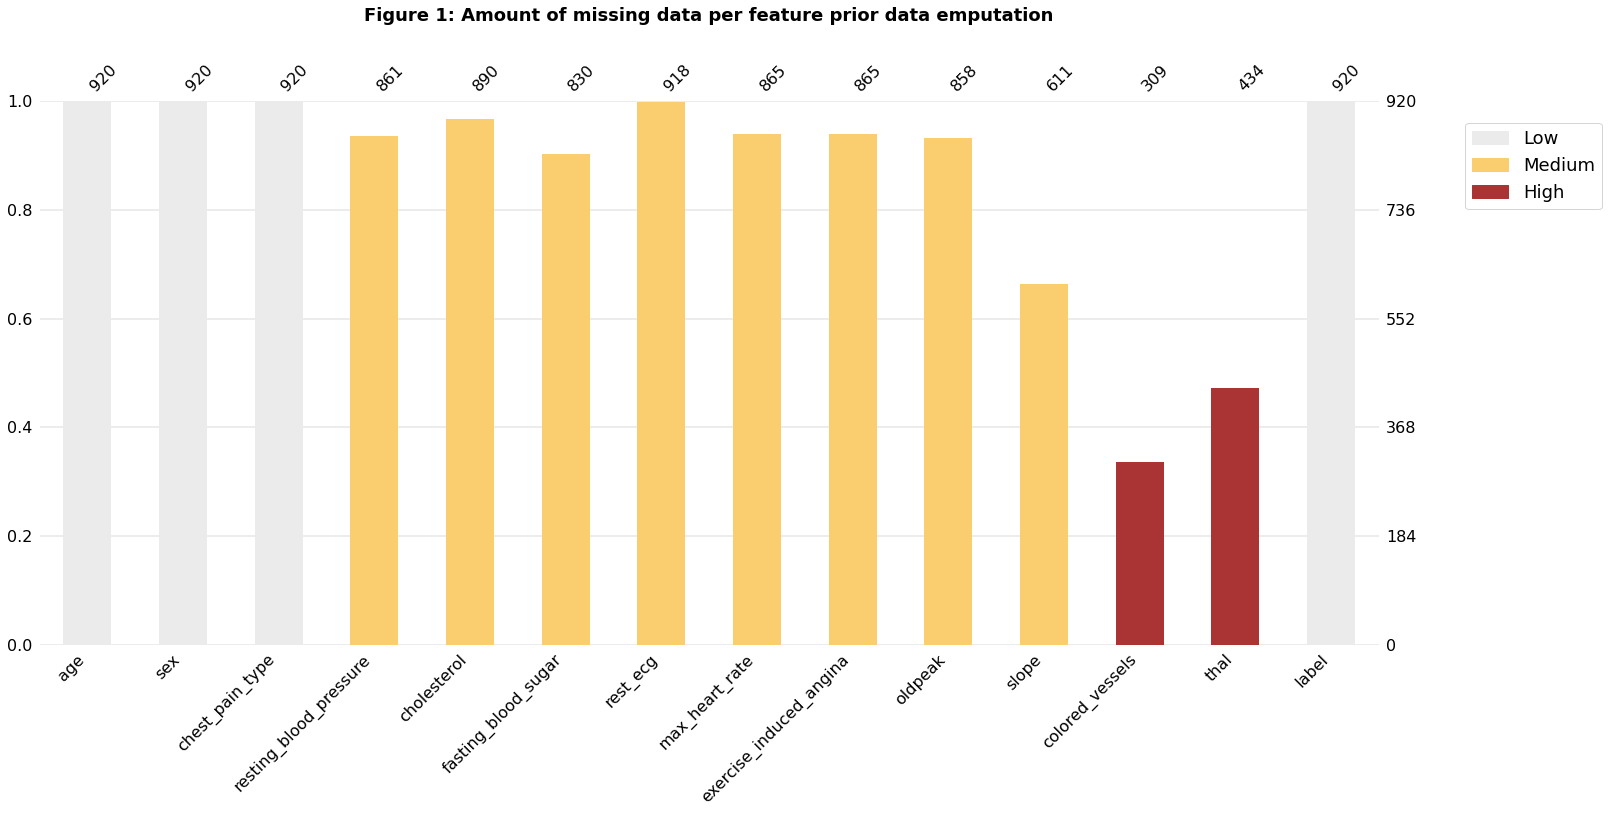

In [9]:
missing_val_plot(df, 'Figure 1: Amount of missing data per feature prior data emputation')

'Colored_vessels' and 'thal' have more than half of the instances with missing values, we therefore decide to remove
these columns.

In [10]:
# Drop 2 columns
df = df.drop(columns=['colored_vessels', 'thal'])

## 4.1 Data visualisation

We observe the distribution of the different features, and their correlation with the observed diagnosis.

In [11]:
## Change datatypes for the different columns

categorical_var = ['sex','chest_pain_type', 'fasting_blood_sugar','rest_ecg', 'exercise_induced_angina',
                   'slope', 'label']
numerical_var = ['age','resting_blood_pressure', 'cholesterol', 'max_heart_rate', 'oldpeak']

for col in categorical_var:
    df[col] = df[col].fillna(-99)
    df[col] = df[col].astype('int64')
    df[col] = df[col].replace(-99, np.NaN)
    df[col] = df[col].astype('category')
        

for col in numerical_var:
    df[col] = df[col].astype('float')

In [12]:
## Plot the distribution of numerical variables
from itertools import combinations
import matplotlib.pyplot as plt

def plot_num_var(df, title):
    # Main figure formatting
    size_plot = int((len(numerical_var)/2)+1)
    graph_dim = (15,15)
    color = color_main
    fig, axes = plt.subplots(ncols=2, nrows=size_plot, figsize = graph_dim)
    fig.suptitle(title, fontweight = 'bold', fontsize = 12)

    i = 0
    for triaxis in axes:
        for axis in triaxis:
            if i < ((size_plot*2)-1):
                df.hist(column = numerical_var[i], bins = 50, ax=axis, color = color)
                graph = axes.flat[i] #Extract coordinates of for the graph being plotted
                graph.grid(False, axis = 'x') # Remove vertical gridlines
                graph.grid(True, axis = 'y', color='gray', linewidth=0.3) #Format horizontal grid lines
                graph.title.set_text(numerical_var[i])

            else:
                break
            i = i +1
            axes.flat[-1].set_visible(False) # Hide last empty plot

    fig.tight_layout(pad=2, w_pad=4, h_pad=3.0)

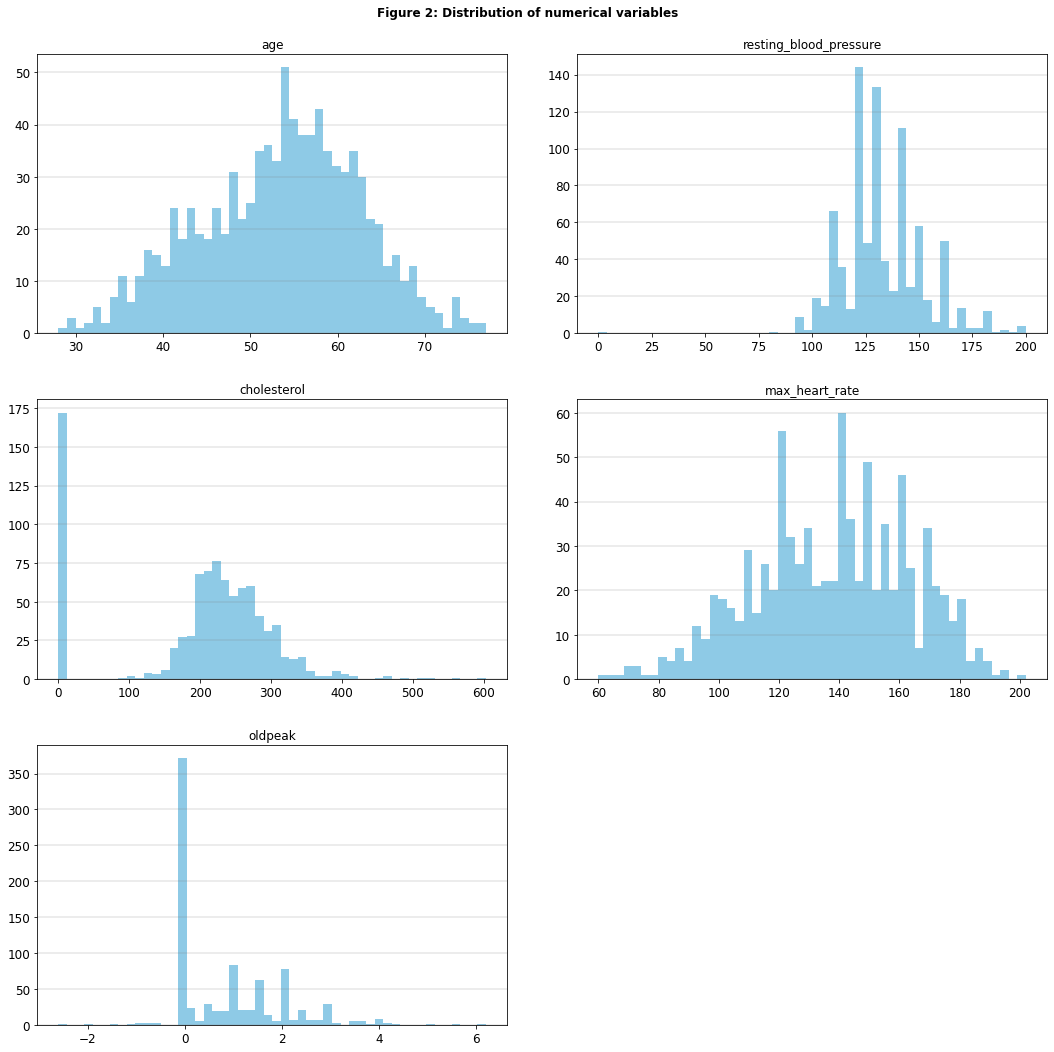

In [13]:
plot_num_var(df, 'Figure 2: Distribution of numerical variables')

Based on the distribution of values for 'cholesterol', we assume that null values are missing values, and therefore replace them. For the variable 'oldpeak', the distinction is harder to make without further information on the data collection process. Therefore we take the assumption that null values are actual results, and null values are kept.

In [14]:
## Replace null values for 'cholestoral'.
df['cholesterol'] = df['cholesterol'].replace(0, np.nan)

In [15]:
## Plot the distribution of numerical variables

def compare_plot_numvariable(df, col, title):

    #Define dataframes to plot
    df_col = df[col]
    df_col_0 = df.loc[df['label'] == 0, col]
    df_col_1 = df.loc[df['label'] == 1, col]
    
    # Format overall figures
    fig3 = plt.figure(figsize = (10,6))
    gs = fig3.add_gridspec(2, 2)
    fig3.suptitle(title, fontweight = 'bold')

    # Create and format main graphs for overall distribution
    f3_ax1 = fig3.add_subplot(gs[0, :])
    y_f3_ax1, x_f3_ax1, _ = f3_ax1.hist(df_col, bins = 50, color= color_main)
    f3_ax1.grid(False, axis = 'x') # Remove vertical gridlines
    f3_ax1.grid(True, axis = 'y', color='gray', linewidth=0.3)
    f3_ax1.set_title('Distribution of ' + col + ' for all diagnosis')

    # Create and format secondary graphs for distribution of healthy patients
    f3_ax2 = fig3.add_subplot(gs[1:, 0])
    y_f3_ax2, x_f3_ax2, _ = f3_ax2.hist(df_col_0, bins = 50, color= color_healthy)
    f3_ax2.grid(False, axis = 'x') # Remove vertical gridlines
    f3_ax2.grid(True, axis = 'y', color='gray', linewidth=0.3)
    f3_ax2.set_title('Distribution of ' + col +' for healthy patients')

    # Create and format secondary graphs for distribution of sick patients
    f3_ax3 = fig3.add_subplot(gs[1:, 1:])
    y_f3_ax3, x_f3_ax3, _ = f3_ax3.hist(df_col_1, bins = 50, color= color_sick)
    f3_ax3.grid(False, axis = 'x') # Remove vertical gridlines
    f3_ax3.grid(True, axis = 'y', color='gray', linewidth=0.3) # Remove vertical gridlines
    f3_ax3.set_title('Distribution of ' + col +' for sick patients')
    
    # Set up axes scale for the comparative graphs to be the same
    min_height = min((y_f3_ax2.min()*1.1), (y_f3_ax3.min()*1.1))
    max_height = max((y_f3_ax2.max()*1.1), (y_f3_ax3.max()*1.1))
    min_len = min((x_f3_ax2.min()*1.1), (x_f3_ax3.min()*1.1))
    max_len = max((x_f3_ax2.max()*1.1), (x_f3_ax3.max()*1.1))
    
    f3_ax2.set_xlim(min_len, max_len)
    f3_ax2.set_ylim(min_height, max_height)
    f3_ax3.set_xlim(min_len, max_len)
    f3_ax3.set_ylim(min_height, max_height)

    # Formatting overall layout for the figures
    fig3.tight_layout(pad=1.5, w_pad=3, h_pad=2.0)

In [16]:
## Plot the distribution of categorical variables

def compare_plot_catvariable(df, col, title, labels):

    #Define dataframes to plot
    df_col = df[col].to_frame()
    df_col_0 = df.loc[df['label'] == 0, col].to_frame()
    df_col_1 = df.loc[df['label'] == 1, col].to_frame()

    # Define maximum values for x axis for secondary figures to have same x axis
    max_height_0 = int(df_col_0.value_counts().max()*1.2)
    max_height_1 = int(df_col_1.value_counts().max()*1.2)
    max_height = max(max_height_0, max_height_1)
    
    # Format overall figures
    fig3 = plt.figure(figsize = (8,6))
    gs = fig3.add_gridspec(2, 2)
    fig3.suptitle(title, fontweight = 'bold')

    # Create and format main graphs for overall distribution
    f3_ax1 = fig3.add_subplot(gs[:, 0])
    sns.countplot(x=col, data=df_col, ax = f3_ax1, color = color_main)
    f3_ax1.grid(False, axis = 'x') # Remove vertical gridlines
    f3_ax1.grid(True, axis = 'y', color='gray', linewidth=0.3)
    f3_ax1.set_title('Distribution of ' + col + ' for all diagnosis')
    f3_ax1.set_xticklabels(labels, rotation=45, fontsize=10)
    f3_ax1.set_xlabel('')

    # Create and format secondary graphs for distribution of healthy patients
    f3_ax2 = fig3.add_subplot(gs[0, 1:])
    sns.countplot(x=col, data=df_col_0, ax = f3_ax2, color = color_healthy)
    f3_ax2.set_ylim(0, max_height)
    f3_ax2.grid(False, axis = 'x') # Remove vertical gridlines
    f3_ax2.grid(True, axis = 'y', color='gray', linewidth=0.3)
    f3_ax2.set_title('Distribution of ' + col +' for healthy patients')
    f3_ax2.set_xticklabels(labels, rotation=45, fontsize=10)
    f3_ax2.set_xlabel('')

    # Create and format secondary graphs for distribution of sick patients
    f3_ax3 = fig3.add_subplot(gs[1:, 1:])
    sns.countplot(x=col, data=df_col_1, ax = f3_ax3, color = color_sick)
    f3_ax3.set_ylim(0, max_height)
    f3_ax3.grid(False, axis = 'x') # Remove vertical gridlines
    f3_ax3.grid(True, axis = 'y', color='gray', linewidth=0.3) # Remove vertical gridlines
    f3_ax3.set_title('Distribution of ' + col +' for sick patients')
    f3_ax3.set_xticklabels(labels, rotation=45, fontsize=10)
    f3_ax3.set_xlabel('')

    # Formatting overall layout for the figures
    fig3.tight_layout(pad=1.5, w_pad=14, h_pad=2.0)

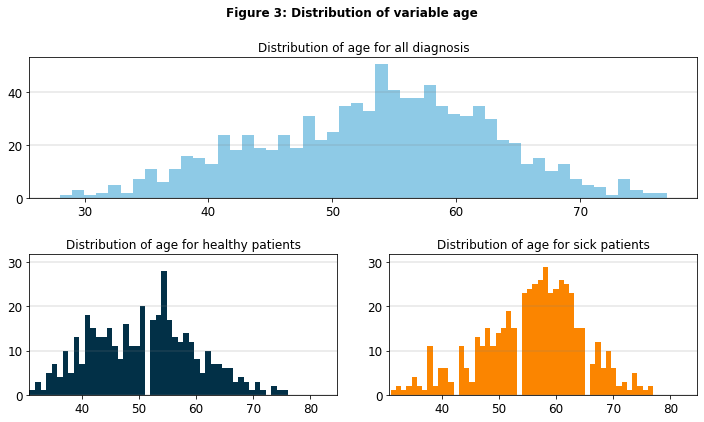

In [17]:
compare_plot_numvariable(df, 'age', 'Figure 3: Distribution of variable age')

We observe that the majority of patients included in our data set are between 50 and 65 years old, and not surprisingly, the distribution for sick patients is slightly skewed towards older patients.

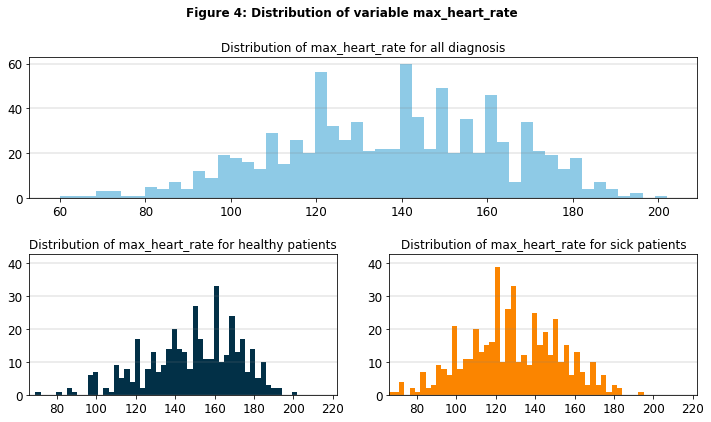

In [18]:
compare_plot_numvariable(df, 'max_heart_rate', 'Figure 4: Distribution of variable max_heart_rate')

Here the maximum heart rate has been mesured during an exercise electrocardiogram (Johns Hopkins Medicine 2021), which  assess the heart's response to exercise. In line with the findings from the litterature (Cay, S. et al. 2009), the presence of heart disease decreases heart rate increment, and decreases heart rate decrement, during exercise, hence why we see the distribution for sick patients skewed towards lower values.

We now take a look at the distribution of a few of our categorical variables and their correlation with our labels.

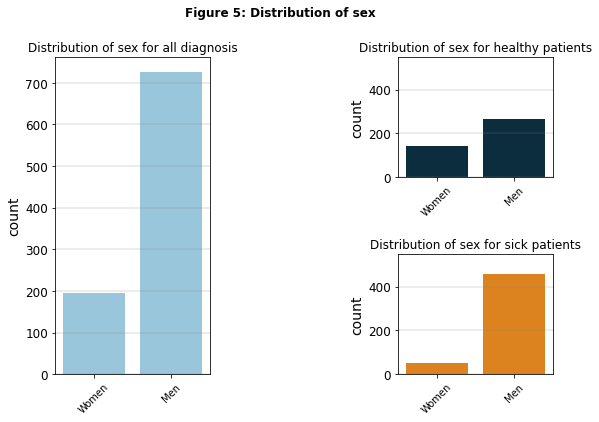

In [19]:
labels_sex = ['Women', 'Men']
compare_plot_catvariable(df, 'sex', 'Figure 5: Distribution of sex', labels_sex)

Sick patients appear to be for the  large majority mens, which is again expected in line with common knowledge (Sabay et al. 2018), but the case here to a particularily high level.

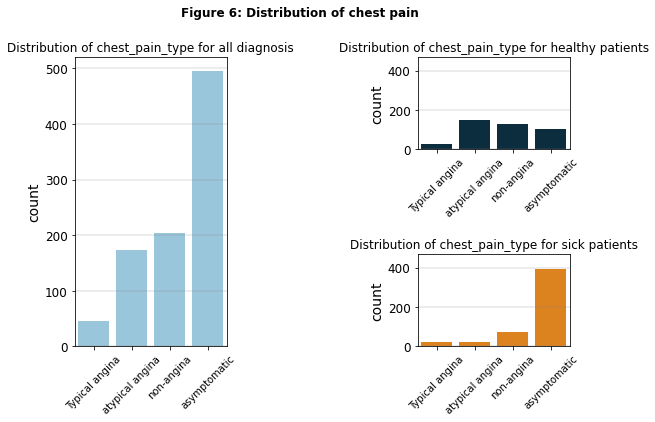

In [20]:
labels_chest = ['Typical angina', 'atypical angina', 'non-angina', 'asymptomatic']
compare_plot_catvariable(df, 'chest_pain_type', 'Figure 6: Distribution of chest pain', labels_chest)

We observe here that asymptomatic chest pain is much more likely to be present for sick patients. This supports the fact that clinicians should be alert of heart disease also in the absence of chest pain symptoms (Harvard Health Publishing 2017).

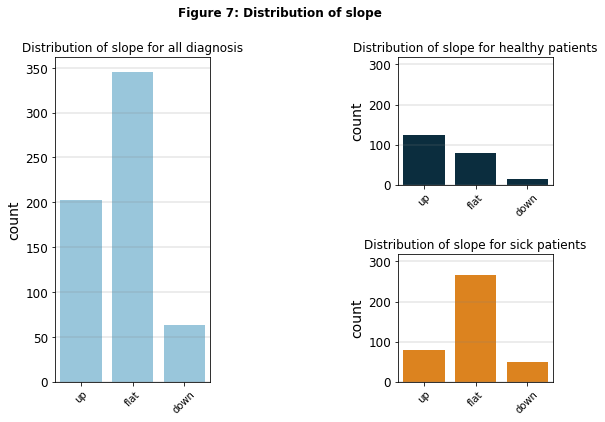

In [21]:
labels_slope = ['up', 'flat', 'down']
compare_plot_catvariable(df, 'slope', 'Figure 7: Distribution of slope', labels_slope)

ST segment represents the period in which the myocardium maintains contraction to expel blood from the ventricles, and ST depression occurs when this segment is below the baseline (Kashou, Basit and Malik, 2020).

Based on the above, we observe that patients with a flat line within the ST depression segment of their electrocardiogram (cf. Appendix 2)  appear to be much more likely to be sick patients.

We then also have a quick look at the corroletation between the different features and the labels. Due to the fact that regular correlation matrix may miss non-linear relationship, we use a scatter matrix.

<Figure size 576x432 with 0 Axes>

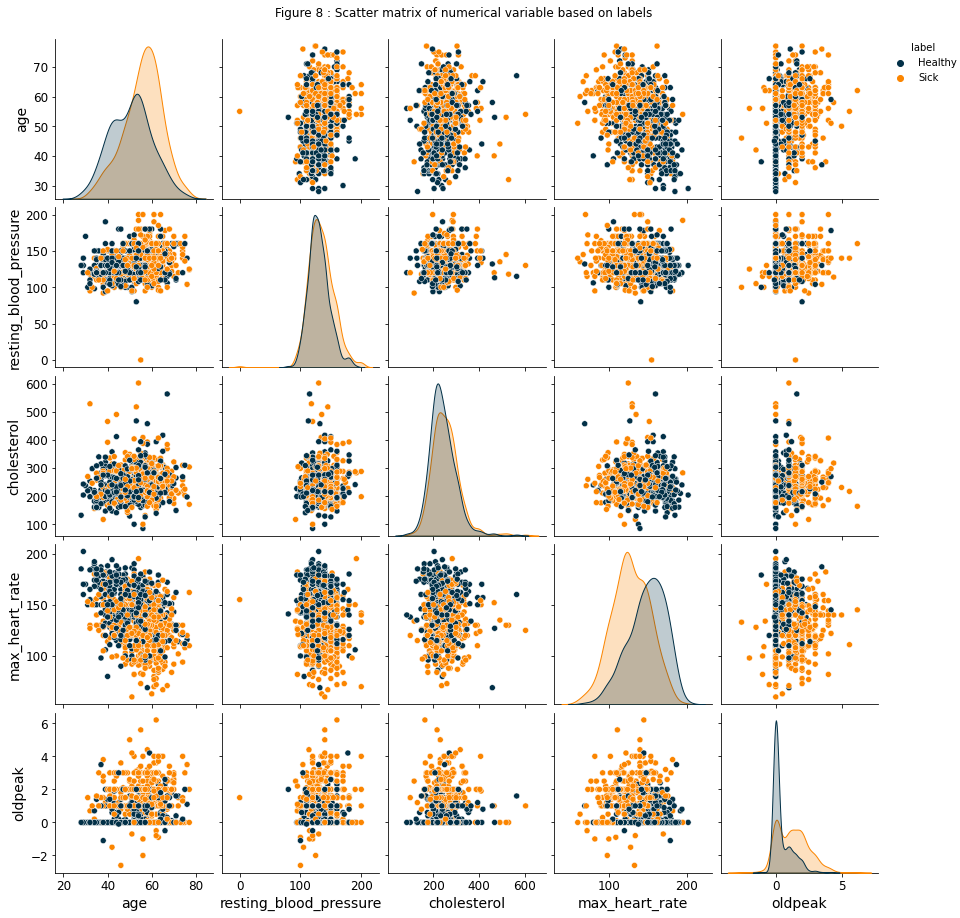

In [22]:
%matplotlib inline

df_scatter = df.loc[:, numerical_var]
df_scatter['label'] = df['label']

colors_pal = [color_healthy, color_sick]# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors_pal))

title = 'Figure 8 : Scatter matrix of numerical variable based on labels'
fig = plt.figure(figsize = (8,6))
fig.suptitle(title, fontweight = 'bold', fontsize = 12)

g = sns.pairplot(df_scatter, hue = 'label', palette = customPalette)

g.fig.suptitle(title, y=1.02)

# replace labels
new_labels = ['Healthy', 'Sick']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g._legend.set_bbox_to_anchor((1.025, 0.95))

We observe quite limited correlation across the different numerical features of our data set. Potentially only 'age' and 'max_heart_rate' display a certain correlation. However due to the lack of clear relationship, we decide to not explore this relationship further and ot to create any additional feature based on this observation.

Due to the limited number of features and time available, we also do not perform any data dimensionality reduction technique.

## 4.2 Data cleaning and data emputation 

Now we perform a second round of data cleaning and replace all missing values to enable further data processing.

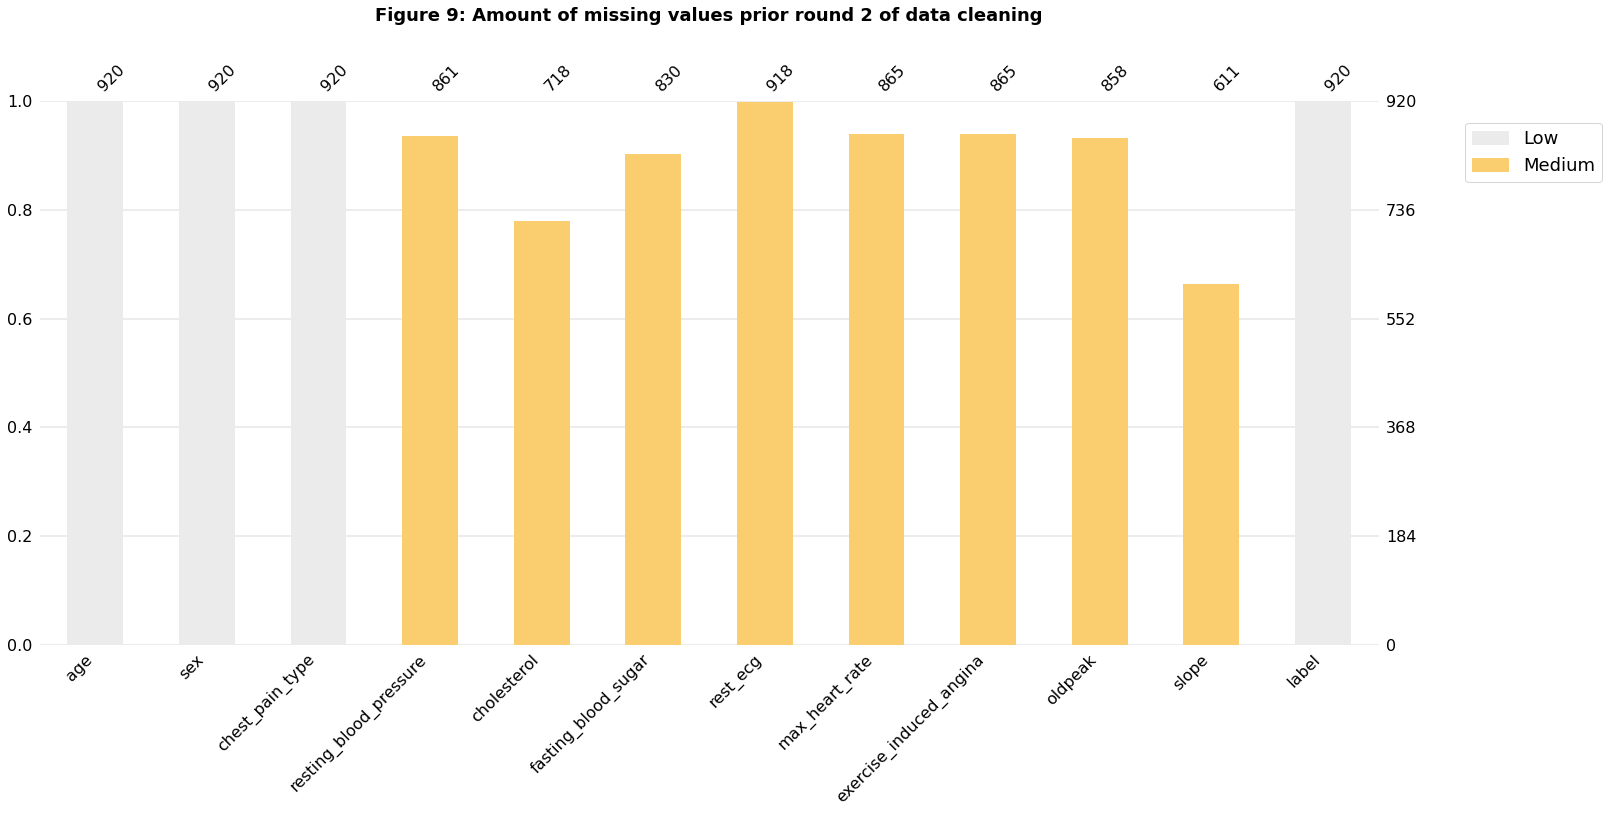

In [23]:
# Plot the number of missing values per attributes
missing_val_plot(df, 'Figure 9: Amount of missing values prior round 2 of data cleaning')

In [24]:
## Input median for missing values within numerical variables:

# 1. Remove categorial 
df_float = df.select_dtypes(exclude=   
                 ["category"]).copy()

# 2. Fit the numerical data to Imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
imputer.fit(df_float)

# 3. Create transformed dataframe
X = imputer.transform(df_float)
df_tr = pd.DataFrame(X, columns=df_float.columns, 
                    index=df_float.index)


df["resting_blood_pressure"] = df_tr["resting_blood_pressure"]
df["cholesterol"] = df_tr["cholesterol"]
df["max_heart_rate"] = df_tr["max_heart_rate"]
df["oldpeak"] = df_tr["oldpeak"]

In [25]:
## Values are still missing for certain categorial columns:

# 'rest_ecg' has only 2 value missing, here we replace it by the most common category which is '0'
df['rest_ecg'] = df['rest_ecg'].fillna(0)

# 'fasting_blood_sugar' and 'exercise_induced_angina' also have a limited number of number of values missing, therefore
# we replace it by the most common category also which is '0'
df['fasting_blood_sugar'] = df['fasting_blood_sugar'].fillna(0)
df['exercise_induced_angina'] = df['exercise_induced_angina'].fillna(0)

# 'slope' has a large number of missing values, and therefore we create an additional category for these values '0'
#df['slope'] = df['slope'].cat.add_categories(0)
df['slope'] = df['slope'].cat.add_categories([0])
df['slope'] = df['slope'].fillna(0)

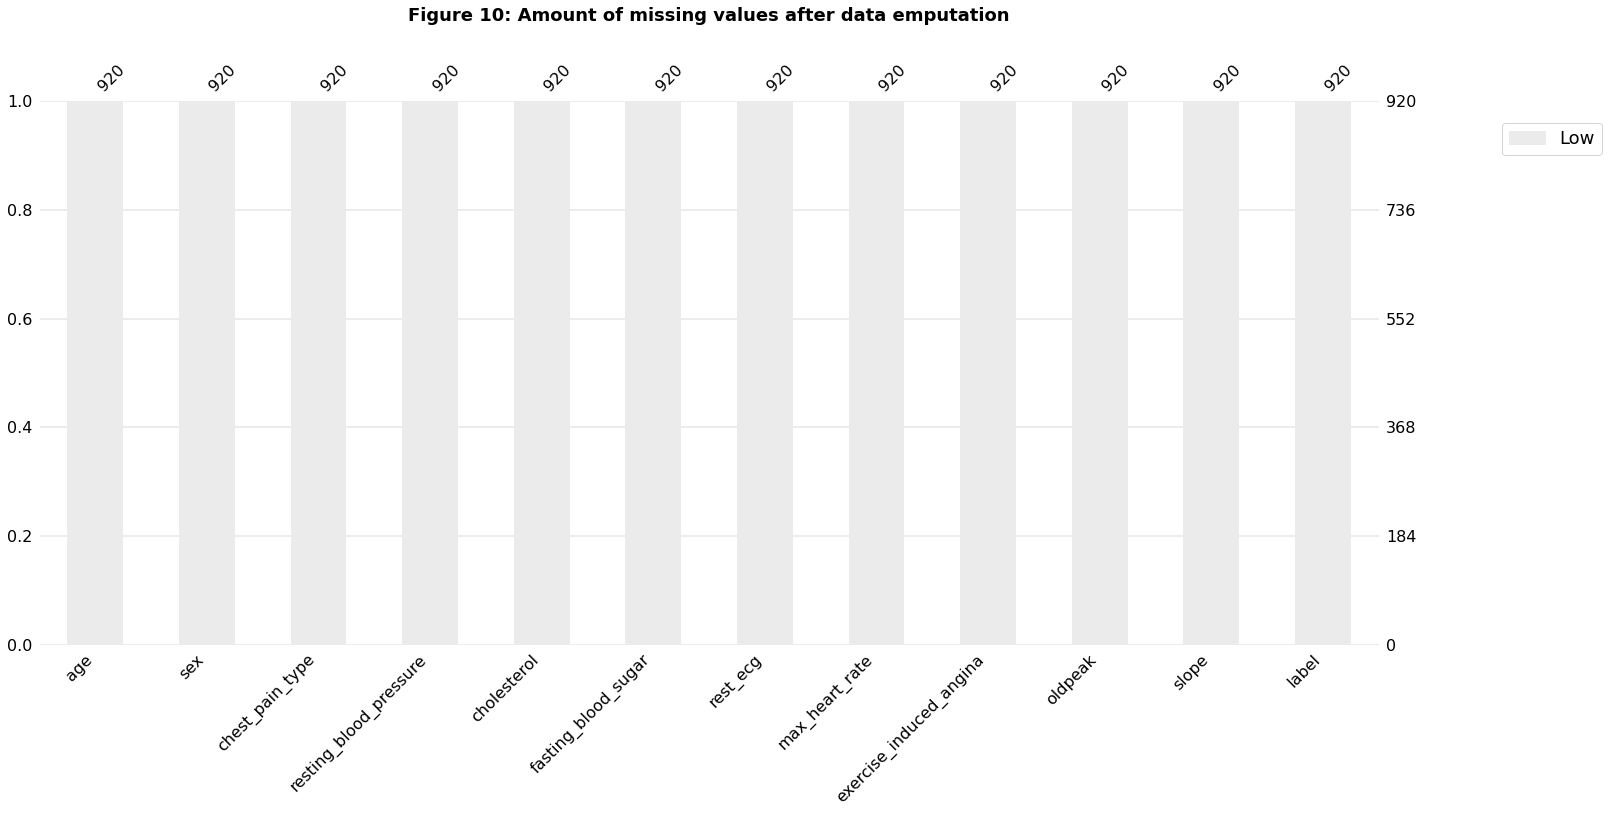

In [26]:
# We verify that we have no missing values within the entire dataset
missing_val_plot(df, 'Figure 10: Amount of missing values after data emputation')

 The data set has no longer any missing value, and can be further processed.

# 5. Data preparation

We first need to split our data in a training set and a testing set. Due to the limited size of our sample, we use a stratified sampling method to ensure a fair representation of the different categories and values of each features within both the training set and the testing set.

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state = seed_value)
for train_index, test_index in split.split(df, df['label']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

We seperate the labels and the rest of the features for the training set.

In [28]:
train = train_set.drop("label", axis=1)
train_label = train_set["label"].copy()

Then we perform the feature scaling on our data by performing one hot encoding for categorical variables, and standard scaling to limit the effect of the few outliers we may have for the continuous variables.

In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

def pre_process(df, categorical, numerical):
    # Perform one-hot encoding for categorical variables
    cat = df[categorical]
    encoder = OneHotEncoder()
    one_hot_cat = encoder.fit_transform(cat).toarray()
    
    # Perform standard scaling for numerical variables
    scaler = StandardScaler() #Centers the training set automaticcaly which will be useful for SVM
    continuous = scaler.fit_transform(df[numerical])
    
    processed_array = np.concatenate((one_hot_cat, continuous), axis=1)
    return processed_array

In [30]:
# Apply pre-processing function on our training data set
train_data = pre_process(train, categorical_var[:-1], numerical_var)

In [31]:
## Quick glance at what the traning input data looks like 
train_df = pd.DataFrame(data = train_data)
train_df

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.027115,-0.118100,-0.863024,0.082496,-0.352175
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-1.031179,-1.206173,-0.987248,1.554940,-0.832482
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-1.242838,-0.662137,-0.738800,1.395757,-0.832482
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,-1.454497,0.425937,-0.945840,1.594736,0.512377
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-1.560326,0.317130,-0.511057,0.560045,-0.832482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.027115,3.254928,0.793293,2.271264,-0.832482
640,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.027115,-1.206173,-0.800912,-1.190969,-0.832482
641,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.556262,0.425937,-1.401327,0.958003,-0.832482
642,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,-1.666155,-1.206173,-1.007952,1.117186,-0.832482


# 6. Model selection and training

Now that the data is ready to be processed, we will go through several potential models, assessing different performance metrics before selecting a particular model for which we will fine-tune the hyperparameters.

In [32]:
## Create variables for the different part of the data set for consistency

x_train = train_data
y_train = train_label

We create a split within the training set, to be able to compare the results of our fine tuning against a validation set.

In [33]:
from sklearn.model_selection import train_test_split

x_tuning, x_val, y_tuning, y_val  = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

In order to effectively assess the performance of our models in the context of a classificaiton problem, we decide to create our own performance metric, which will be a composite of the accuracy (which assess the overall predictive power of the model) and of the precision and recall score, with an emphasis on the recall score. Indeed in the context of a medical diagnosis and predictions, it is more important to categorize all "at-risk" patients correctly, even if some false alarms are raised. 

In [34]:
## Function to compute performance metrics for each model

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from statistics import mean
import time

def perf_scores(model, x_train, y_train, cv_folds):
    
    #Set-up
    tic = time.perf_counter() # Set timer value at the beginning of the scoring process
    scores = {}
    
    # Compute regular performance metrics based on confusion matrix
    y_train_pred = cross_val_predict(model, x_train, y_train, cv = cv_folds, method = 'predict' )
    conf_matrix = confusion_matrix(y_train, y_train_pred)
    cross_val_result = cross_val_score(model, x_train, y_train, cv= cv_folds, scoring="accuracy")
    precision_val = precision_score(y_train, y_train_pred)
    recall_val = recall_score(y_train, y_train_pred)
    f1_val = f1_score(y_train, y_train_pred)
    
    # Compute metrics for the RoC curve, with try and except for the different types of models
    try:
        y_scores = cross_val_predict(model, x_train, y_train, cv=cv_folds, method="decision_function")
        fpr, tpr, thresholds = roc_curve(y_train, y_scores)
        roc_auc_val = roc_auc_score(y_train, y_scores)
    except:
        y_scores = cross_val_predict(model, x_train, y_train, cv=cv_folds, method="predict_proba")
        y_scores_proba = y_scores[:, 1]
        fpr, tpr, thresholds = roc_curve(y_train, y_scores_proba) 
        roc_auc_val = roc_auc_score(y_train, y_scores_proba)
    
    # Define our own performance metric
    performance_metric = (0.5*mean(cross_val_result))+(0.4*recall_val)+(0.1*precision_val)
    
    # Populate the dictionary with the computed values
    scores['accuracy'] = round(mean(cross_val_result),3)
    scores['precision'] = round(precision_val,3)
    scores['recall'] = round(recall_val, 3)
    scores['f1_score'] = round(f1_val, 3)
    scores['roc_auc'] = round(roc_auc_val, 3)
    scores['performance_metric'] = round(performance_metric, 3)
    
    # Mesure time to process
    toc = time.perf_counter() # Set timer value at the end of the scoring process
    scores['training_time_sec'] = round((toc-tic),3)

    return scores

In [35]:
## Function to compute performance metrics for several models

def perf_scores_list(model_list, x_train, y_train, cv_folds):
    scores_list = {}
    
    #Loop through all models of the list to compute the scores
    for model in model_list:
        perf = perf_scores(model, x_train, y_train, cv_folds)
        
        # Append scores values to dictionary
        scores_list.setdefault('model',[]).append(str(model).split('(')[0])
        scores_list.setdefault('accuracy',[]).append(perf.get('accuracy'))
        scores_list.setdefault('precision',[]).append(perf.get('precision'))
        scores_list.setdefault('recall',[]).append(perf.get('recall'))
        scores_list.setdefault('f1_score',[]).append(perf.get('f1_score'))
        scores_list.setdefault('roc_auc',[]).append(perf.get('roc_auc'))
        scores_list.setdefault('performance_metric',[]).append(perf.get('performance_metric'))
        scores_list.setdefault('training_time_sec',[]).append(perf.get('training_time_sec'))
        
    # Create dataframe for better visual
    scores_list_df = pd.DataFrame.from_dict(scores_list)
        
    return scores_list_df

In [36]:
## Function to plot roc curve for one method

def roc_curve_graph(model, x_train, y_train, cv_folds):
    model_name = str(model).split('(')[0] # To extract name of the model based on input
    
    # Compute metrics to plot a single model
    y_scores = cross_val_predict(model, x_train, y_train, cv=cv_folds, method="decision_function")
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    plt.plot(fpr, tpr, "b:", label=model_name)
    
    # Formatting
    plt.xlabel('False positive rate')
    plt.ylabel('True Positive rate (Recall)')
    plt.title(title, {'fontsize': 16}, pad = 10)
    plt.legend(loc="lower right")
    plt.show()

In [37]:
## Function to plot roc curve for multiple methods

def roc_curve_graphs(models, x_train, y_train, cv_folds, title):
    colors = ['red' , 'blue', 'green','red' , 'blue', 'green','red' , 'blue', 'green', 'red' , 'blue',
              'green', 'red' , 'blue', 'green', 'red' , 'blue', 'green']
    
    # Loop to plot the different models
    i = 0
    for model in models:
        try:
            y_scores = cross_val_predict(model, x_train, y_train, cv=cv_folds, method="decision_function")
            fpr, tpr, thresholds = roc_curve(y_train, y_scores)
        except:
            y_scores = cross_val_predict(model, x_train, y_train, cv=cv_folds, method="predict_proba")
            y_scores_proba = y_scores[:, 1]
            fpr, tpr, thresholds = roc_curve(y_train, y_scores_proba)
            
        plt.plot(fpr, tpr, "b:", color = colors[i], label= str(models[i]).split('(')[0])
        i = i+1
        
        
    # Formatting    
    plt.xlabel('False positive rate')
    plt.ylabel('True Positive rate (Recall)')
    plt.title(title, {'fontsize': 12}, pad = 10)
    plt.legend(loc="lower right")
    plt.show()

We test a number of different models, applicable to classfication problems. We start with simple ones and extend to ensemble models, which we expect to perform better as complexity increases.

In [38]:
## 1. Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=seed_value)
sgd_clf.fit(x_tuning, y_tuning)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
## 2. Logistic regression
from sklearn.linear_model import LogisticRegression

class_w = df.label.value_counts()/len(df)
logistic_reg = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=seed_value)
logistic_reg.fit(x_tuning, y_tuning)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=42, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [40]:
## 3. Linear Support Vector Machine
from sklearn.svm import LinearSVC

svm_linear_clf = LinearSVC(C=1, loss="hinge", max_iter=10000, random_state=seed_value)
svm_linear_clf.fit(x_tuning, y_tuning)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=10000, multi_class='ovr',
          penalty='l2', random_state=42, tol=0.0001, verbose=0)

In [41]:
## 4. Polynomial Kernel
from sklearn.svm import SVC

poly_kernel_svm_clf = SVC(kernel="poly", degree=3, coef0=1, C=5, random_state=seed_value)
poly_kernel_svm_clf.fit(x_tuning, y_tuning)

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [42]:
## 5. Voting classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf_vt = LogisticRegression(random_state=seed_value)
rnd_clf_vt = RandomForestClassifier(random_state=seed_value)
svm_clf_vt = SVC(probability = True, random_state=seed_value)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf_vt), ('rf', rnd_clf_vt), ('svc', svm_clf_vt)],
    voting='soft')
voting_clf.fit(x_tuning, y_tuning)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [43]:
## 6. Random forest classifier
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=50, max_leaf_nodes=25, n_jobs=-1, random_state=seed_value)
rnd_clf.fit(x_tuning, y_tuning)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=25, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [44]:
## 7. Adaboost classifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=20, random_state = seed_value),
    n_estimators=500, algorithm="SAMME.R", learning_rate=0.8)
ada_clf.fit(x_tuning, y_tuning)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=20,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                         

In [45]:
## 8. Gradient boosting classifier

from sklearn.ensemble import GradientBoostingClassifier

gbrt_clf = GradientBoostingClassifier(max_depth=20, n_estimators=50, learning_rate=1.0, random_state = seed_value)
gbrt_clf.fit(x_tuning, y_tuning)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=20,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [46]:
## 9. Extra Tree Classifier

from sklearn.ensemble import ExtraTreesClassifier

extra3_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state = seed_value)
extra3_clf.fit(x_tuning, y_tuning)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=16, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [47]:
## 10. XGBoost classifier
import xgboost

xgb_clf = xgboost.XGBClassifier(learning_rate=0.3, n_estimators=50, max_depth=25, objective = 'binary:logistic', 
                               random_state = seed_value, use_label_encoder=False, eval_metric = 'aucpr')
xgb_clf.fit(x_tuning, y_tuning)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=25, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=8,
              num_parallel_tree=1, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [48]:
## 11. Bag tree classifier 

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_tree_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=25, random_state = seed_value), n_estimators=50,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_tree_clf.fit(x_tuning, y_tuning)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=25,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=42,
    

In [49]:
model_list_1 = [sgd_clf, logistic_reg, svm_linear_clf, poly_kernel_svm_clf, 
                voting_clf, rnd_clf, ada_clf, gbrt_clf, extra3_clf, xgb_clf, bag_tree_clf]
model_list_1_perf = perf_scores_list(model_list_1, x_tuning, y_tuning, 10)

In [50]:
## Check results and sort by our performance metric

model_list_1_perf.sort_values(by=['performance_metric'], ascending = False)

,model,accuracy,precision,recall,f1_score,roc_auc,performance_metric,training_time_sec
8,ExtraTreesClassifier,0.807,0.781,0.906,0.839,0.871,0.844,12.612
5,RandomForestClassifier,0.807,0.790,0.888,0.836,0.878,0.838,2.775
4,VotingClassifier,0.809,0.801,0.873,0.835,0.879,0.834,6.673
10,BaggingClassifier,0.789,0.787,0.873,0.828,0.871,0.822,1.654
9,XGBClassifier,0.791,0.790,0.846,0.817,0.843,0.813,1.492
2,LinearSVC,0.781,0.780,0.839,0.809,0.873,0.804,0.229
1,LogisticRegression,0.778,0.803,0.794,0.798,0.876,0.787,0.318
3,SVC,0.762,0.768,0.816,0.791,0.802,0.784,0.354
6,AdaBoostClassifier,0.737,0.761,0.775,0.768,0.726,0.755,0.117
7,GradientBoostingClassifier,0.741,0.765,0.768,0.766,0.822,0.754,1.134


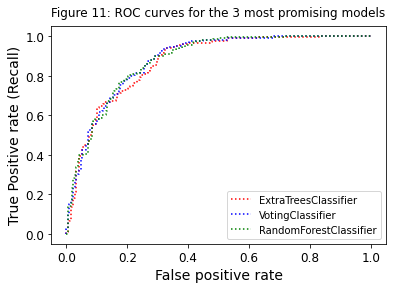

In [51]:
model_list_2 = [extra3_clf, voting_clf, rnd_clf]
roc_curve_graphs(model_list_2 , x_tuning, y_tuning, 10, 'Figure 11: ROC curves for the 3 most promising models')

We observe that despite the fact that the Extra Trees classifier does not perform as well on the ROC curve as the other models around the elbow, it does display the highest score on our performance metric. 

Extremely Randomized Trees ensemble are very similar to random forest algorithms, but differ by adding an additional layer of randomness in their approach, by randomizing strongly both attribute and cut-point choice while splitting a tree node (Geurts, Ernst and Wehenkel 2006). They supposidely trade for more biais more a higher variance, and should hopefully be less prone to overfitting (Géron, 2019).

# 7. Model fine-tuning

Based on the review of several references on the topic ((Van Rijn and Hutter, 2017), (Probst, Wright and Boulesteix 2019), and (Saxena 2020)), and the importance of the different hyperparameters of random forest classifiers discussed within these articles, we decide to select a sub-set of all the hyperparameters for extra trees to fine tune as follows:

In [ ]:
## List of selected hyperparameters for the fine tuning of the Extra Trees Classifier

1 - n_estimators #The number of trees in the forest (default to 100)
2 - max_leaf_nodes # Grow trees with max_leaf_nodes in best-first fashion
3 - criterion #The function to measure the quality of a split ('gini' or 'entropy')
4 - max_depth # The maximum depth of the tree
5 - min_samples_split # The minimum number of samples required to split an internal node
6 - min_samples_leaf # The minimum number of samples required to be at a leaf node.
7 - max_features # The number of features to consider when looking for the best split
8 - bootstrap # Whether bootstrap samples are used to build trees. False = whole dataset is used to build each tree.

## 7.1 Fine-tuning Functions

In [52]:
## Define scoring for grid search
scoring_var = {'Accuracy': 'accuracy', 'Recall': 'recall', 'Precision': 'precision'}

In [53]:
## Highlight function for visualisation of results

def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: #f5ffed' if is_max.any() else '' for v in is_max]

In [54]:
## Function to visualise results of the grid-search in a dataframe

def grid_results(model):
    pd.set_option('display.max_colwidth', 0)
    df_results = pd.DataFrame(model.cv_results_)
    
    # Create new dataframe for easier visualisation
    view = ['mean_fit_time', 'params', 'mean_train_Accuracy','mean_train_Recall', 'mean_train_Precision']
    df_view = df_results.loc[:, view]
    
    # Create new column for our performance metric
    df_view['Perf_metric'] =  (0.5*df_results.loc[:, 'mean_train_Accuracy'])+(0.4*df_results.loc[:, 'mean_train_Recall'])+(0.1*df_results.loc[:, 'mean_train_Precision'])
    
    return df_view

In [55]:
## Function to visualise results for the fine-tuning and highlight best row
def highlight_best(df):
    return df.style.apply(highlight_greaterthan, column = 'Perf_metric', threshold = df['Perf_metric'].max() , axis = 1)

In [56]:
## Function to take both tuning set and validation set values for a specific parameter
def table_param(df_tuning, df_val, parameter):
    parameter_df = df_tuning['params'].copy().to_frame()
    parameter_df['Perf_metric_tuning'] = df_tuning['Perf_metric'].copy()
    parameter_df['Perf_metric_val'] = df_val['Perf_metric'].copy()

    param_val = []
    for i in parameter_df['params']:
        x = (i.get(parameter))
        param_val.append(x)

    parameter_df['param_val'] = param_val
    parameter_df = parameter_df.set_index('param_val')
    
    return parameter_df

In [57]:
## Plot the learning curves for a certain parameter

def plot_learning(df, param, title):

    # Format overall figures
    fig = plt.figure(figsize = (15,4))
    gs = fig.add_gridspec(1, 2)
    fig.suptitle(title, fontweight = 'bold')

    # Create first graph for tuning set
    f_ax2 = fig.add_subplot(gs[0, 0])
    df['Perf_metric_tuning'].plot.line(ax = f_ax2, color = color_tuning, linewidth = 2)
    f_ax2.set_title('Learning curve with tuning set')

    # Create second graph for validation set
    f_ax3 = fig.add_subplot(gs[0, 1])
    df['Perf_metric_val'].plot.line(ax = f_ax3, color = color_validation, linewidth = 2)
    f_ax3.set_title('Learning curve with validation set')

    #Common formatting
    for i in [f_ax2, f_ax3]:
        i.grid(False, axis = 'x') # Remove vertical gridlines
        i.grid(True, axis = 'y', color='gray', linewidth=0.3)
        i.set_ylabel('Performance')
        i.set_xlabel(param)

    # Formatting overall layout for the figures
    fig.tight_layout(pad=1.5, w_pad=3, h_pad=2.0)

## 7.2 Fine-tuning process

We perform the fine-tuning of the model by using the grid search method over the chosen hyperparameters to further understand the impact of each hyperparameter on the model performance. We will then use the best value found for each parameter to determine the value of the next hyperparameter.

### 7.2.1 'n_estimators'

We start our fine tuning exercise with the 'n-estimators' parameter.

In [58]:
## First round of fine-tuning with tuning set - n_estimators

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [10 , 25, 40 , 50, 75, 100], 'max_leaf_nodes': [30]}
  ]

extra3_clf_grid = ExtraTreesClassifier(random_state = seed_value)

grid_search_1 = GridSearchCV(extra3_clf_grid, param_grid, cv= 10,
                           scoring= scoring_var,
                           return_train_score=True,
                           refit = 'Recall')

grid_search_1_tuning = grid_search_1.fit(x_tuning, y_tuning)

In [59]:
# Results of first grid search on n_estimators with tuning set
grid_1_tuning = grid_results(grid_search_1_tuning)
highlight_best(grid_1_tuning)

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.010429,"{'max_leaf_nodes': 30, 'n_estimators': 10}",0.881985,0.957963,0.848281,0.909006
1,0.021542,"{'max_leaf_nodes': 30, 'n_estimators': 25}",0.882908,0.968370,0.843170,0.913119
2,0.035164,"{'max_leaf_nodes': 30, 'n_estimators': 40}",0.883598,0.968785,0.843844,0.913697
3,0.042591,"{'max_leaf_nodes': 30, 'n_estimators': 50}",0.884980,0.967535,0.846430,0.914147
4,0.062903,"{'max_leaf_nodes': 30, 'n_estimators': 75}",0.882677,0.967120,0.843581,0.912544
5,0.086143,"{'max_leaf_nodes': 30, 'n_estimators': 100}",0.883369,0.965453,0.845519,0.912418


In [60]:
## First round of fine-tuning with validation set - n_estimators
grid_search_1_val = grid_search_1.fit(x_val, y_val)

In [61]:
# Results of first grid search on n_estimators with validation set
grid_1_val = grid_results(grid_search_1_val)
highlight_best(grid_1_val)

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.009805,"{'max_leaf_nodes': 30, 'n_estimators': 10}",0.971705,0.986281,0.963500,0.976715
1,0.020459,"{'max_leaf_nodes': 30, 'n_estimators': 25}",0.977222,0.988765,0.970640,0.981181
2,0.033794,"{'max_leaf_nodes': 30, 'n_estimators': 40}",0.978602,0.988765,0.973005,0.982107
3,0.057866,"{'max_leaf_nodes': 30, 'n_estimators': 50}",0.979981,0.988765,0.975443,0.983041
4,0.060045,"{'max_leaf_nodes': 30, 'n_estimators': 75}",0.977222,0.988765,0.970655,0.981183
5,0.075833,"{'max_leaf_nodes': 30, 'n_estimators': 100}",0.977912,0.988765,0.971874,0.981650


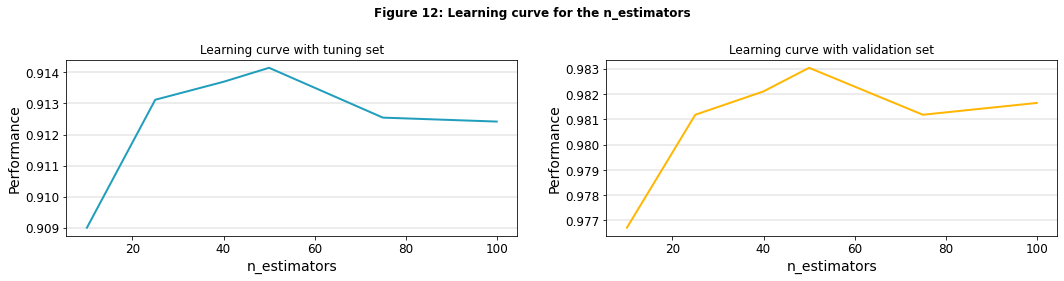

In [62]:
table_param_1 = table_param(grid_1_tuning, grid_1_val, 'n_estimators')
plot_learning(table_param_1, 'n_estimators', 'Figure 12: Learning curve for the n_estimators')

The value of the n_estimators represent the number of trees to grow within our forest. We see that the performance decrease past the threshold of 50, and we therefore decide to limit the number of estimators to this number.

### 7.2.2 'max_leaf_nodes'

This hyperparameters limits the growth of the tree, and the number of final leaf nodes that each trees can have. Having only a limited number of leafs might lead the model to underfit, while having too many may lead the model to overfit.

In [63]:
## Second round of fine-tuning - max_leaf_nodes

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [50],                          # Selected result from previous round
     
     'max_leaf_nodes': [5, 10, 15, 20, 30, 40, 50, 60, 75, 100, 150]}  # Main criteria to test for the second round
  ]

extra3_clf_grid = ExtraTreesClassifier(random_state = seed_value)

grid_search_r2 = GridSearchCV(extra3_clf_grid, param_grid, cv= 10,
                              scoring= scoring_var,
                              return_train_score=True,
                              refit = 'Recall')

grid_search_r2_tuning = grid_search_r2.fit(x_tuning, y_tuning)

In [64]:
grid_2_tuning = grid_results(grid_search_r2_tuning)
highlight_best(grid_2_tuning )

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.039050,"{'max_leaf_nodes': 5, 'n_estimators': 50}",0.807912,0.894296,0.787223,0.840397
1,0.040805,"{'max_leaf_nodes': 10, 'n_estimators': 50}",0.829076,0.924675,0.798152,0.864223
2,0.041823,"{'max_leaf_nodes': 15, 'n_estimators': 50}",0.847478,0.944644,0.810734,0.882670
3,0.042002,"{'max_leaf_nodes': 20, 'n_estimators': 50}",0.861972,0.956295,0.822785,0.895782
4,0.042167,"{'max_leaf_nodes': 30, 'n_estimators': 50}",0.884980,0.967535,0.846430,0.914147
5,0.047042,"{'max_leaf_nodes': 40, 'n_estimators': 50}",0.900622,0.974614,0.863304,0.926487
6,0.046444,"{'max_leaf_nodes': 50, 'n_estimators': 50}",0.913275,0.979604,0.877741,0.936253
7,0.046242,"{'max_leaf_nodes': 60, 'n_estimators': 50}",0.927997,0.983769,0.896231,0.947129
8,0.044712,"{'max_leaf_nodes': 75, 'n_estimators': 50}",0.945712,0.990010,0.918239,0.960684
9,0.048115,"{'max_leaf_nodes': 100, 'n_estimators': 50}",0.973317,0.994589,0.958703,0.980364


In [65]:
## Second round of fine-tuning with validation set - max_leaf_nodes
grid_search_r2_val = grid_search_r2.fit(x_val, y_val)

In [66]:
## Results of second grid search with validation set - max_leaf_nodes
grid_2_val = grid_results(grid_search_r2_val)
highlight_best(grid_2_val)

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.041255,"{'max_leaf_nodes': 5, 'n_estimators': 50}",0.812284,0.832701,0.828983,0.822121
1,0.040004,"{'max_leaf_nodes': 10, 'n_estimators': 50}",0.875776,0.892654,0.884171,0.883367
2,0.042002,"{'max_leaf_nodes': 15, 'n_estimators': 50}",0.922011,0.943827,0.917752,0.930312
3,0.040994,"{'max_leaf_nodes': 20, 'n_estimators': 50}",0.954449,0.977531,0.942476,0.962485
4,0.040048,"{'max_leaf_nodes': 30, 'n_estimators': 50}",0.979981,0.988765,0.975443,0.983041
5,0.040167,"{'max_leaf_nodes': 40, 'n_estimators': 50}",0.992409,0.998750,0.987654,0.994470
6,0.041813,"{'max_leaf_nodes': 50, 'n_estimators': 50}",0.993788,1.000000,0.988904,0.995785
7,0.048834,"{'max_leaf_nodes': 60, 'n_estimators': 50}",1.000000,1.000000,1.000000,1.000000
8,0.056054,"{'max_leaf_nodes': 75, 'n_estimators': 50}",1.000000,1.000000,1.000000,1.000000
9,0.041671,"{'max_leaf_nodes': 100, 'n_estimators': 50}",1.000000,1.000000,1.000000,1.000000


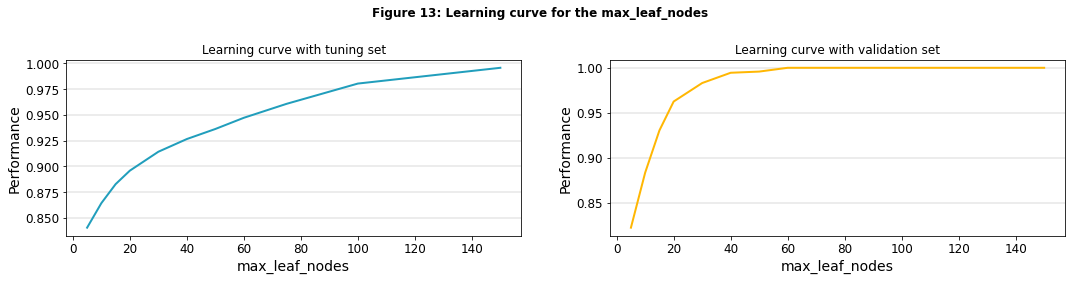

In [67]:
## Visualisation of learning rate for both data set
table_param_2 = table_param(grid_2_tuning, grid_2_val, 'max_leaf_nodes')
plot_learning(table_param_2, 'max_leaf_nodes', 'Figure 13: Learning curve for the max_leaf_nodes')

We see that the maximum number of leaf nodes keeps on increasing the performance for our tuning set, but reaches a plateau for our validation set. Being also aware that a high value is more likely to lead to overfitting, we decide to take a value of 35 for our next iterations, which is near the 'elbow' of our curve for the validation set.

### 7.2.3 'criterion'

Usually the criterion chosen for the function to measure the quality of a split has little impact on the performance model. However we decide to still perform a quick test to observe if changing this parameter makes actually any difference. 

In [68]:
## Third round of fine-tuning - criterion

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [50],              #||
     'max_leaf_nodes': [35],    #|Selected results from previous round
     
     'criterion': ['gini','entropy']}   # Main criteria to test for the third round
  ]

extra3_clf_grid = ExtraTreesClassifier(random_state = seed_value)

grid_search_r3 = GridSearchCV(extra3_clf_grid, param_grid, cv= 10,
                              scoring= scoring_var,
                              return_train_score=True,
                              refit = 'Recall')

grid_search_r3.fit(x_tuning, y_tuning)

GridSearchCV(cv=10, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=42,
                                            verbose=0, warm_start=False),
             iid='deprecated

In [69]:
## Results of third grid search on 'criterion' with tuning set
grid_3 = grid_results(grid_search_r3)
highlight_best(grid_3)

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.045253,"{'criterion': 'gini', 'max_leaf_nodes': 35, 'n_estimators': 50}",0.892800,0.971698,0.854411,0.920520
1,0.044207,"{'criterion': 'entropy', 'max_leaf_nodes': 35, 'n_estimators': 50}",0.886125,0.971696,0.845467,0.916288


In [70]:
## Second round of fine-tuning with validation set - 'criterion'
grid_search_r3_val = grid_search_r3.fit(x_val, y_val)

In [71]:
## Results of third grid search with validation set - 'criterion'
grid_3_val = grid_results(grid_search_r3_val)
highlight_best(grid_3_val)

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.039305,"{'criterion': 'gini', 'max_leaf_nodes': 35, 'n_estimators': 50}",0.983439,0.991265,0.979087,0.986134
1,0.041153,"{'criterion': 'entropy', 'max_leaf_nodes': 35, 'n_estimators': 50}",0.990340,0.998750,0.984026,0.993073


The results are quite difficult to interpret in our case, and we observe a quite limited differences between both results. We take the assumption that better results on the validation set will also translate to better results on our test set, and therefore deicde to go with the entropy criterion.

### 7.2.4 'max_depth'

Similarly to the number of leaf nodes, this parameters also limits the growth of the tree by limiting the lenght of the path between the root node and the leaf node. We can therefore limit the depth of every tree being growth within our model.

In [72]:
## Fourth round of fine-tuning - max_depth

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [50],              #||
     'max_leaf_nodes': [35],            #|Selected results from previous round
     'criterion': ['gini'],          #||
    
     'max_depth':[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25]} # Main criteria to test for the fourth round
  ]

extra3_clf_grid = ExtraTreesClassifier(random_state = seed_value)

grid_search_r4 = GridSearchCV(extra3_clf_grid, param_grid, cv= 10,
                              scoring= scoring_var,
                              return_train_score=True,
                              refit = 'Recall')

grid_search_r4.fit(x_tuning, y_tuning)

GridSearchCV(cv=10, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=42,
                                            verbose=0, warm_start=False),
             iid='deprecated

In [73]:
## Results of fourth grid search with tuning set - 'max_depth'
grid_4_tuning = grid_results(grid_search_r4)
highlight_best(grid_4_tuning)

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.039048,"{'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.802619,0.868077,0.794130,0.827954
1,0.038897,"{'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.823096,0.904288,0.801300,0.853393
2,0.051609,"{'criterion': 'gini', 'max_depth': 6, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.869566,0.956302,0.832710,0.900575
3,0.048851,"{'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.887279,0.966701,0.849991,0.915319
4,0.054797,"{'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.891420,0.970866,0.853078,0.919364
5,0.043273,"{'criterion': 'gini', 'max_depth': 12, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.892800,0.972116,0.854180,0.920665
6,0.042926,"{'criterion': 'gini', 'max_depth': 14, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.893030,0.972114,0.854462,0.920807
7,0.040293,"{'criterion': 'gini', 'max_depth': 16, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.892800,0.971698,0.854411,0.920520
8,0.044801,"{'criterion': 'gini', 'max_depth': 18, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.892800,0.971698,0.854411,0.920520
9,0.043333,"{'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.892800,0.971698,0.854411,0.920520


In [74]:
## Fourth round of fine-tuning with validation set- max_leaf_nodes
grid_search_r4_val = grid_search_r4.fit(x_val, y_val)

In [75]:
grid_4_val = grid_results(grid_search_r4_val)
highlight_best(grid_4_val)

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.044933,"{'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.805378,0.825216,0.823402,0.815116
1,0.043917,"{'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.872328,0.877654,0.890024,0.876228
2,0.039005,"{'criterion': 'gini', 'max_depth': 6, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.965503,0.977531,0.960835,0.969847
3,0.039758,"{'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.981365,0.988765,0.977822,0.983971
4,0.041656,"{'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.984128,0.992500,0.979102,0.986974
5,0.046206,"{'criterion': 'gini', 'max_depth': 12, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.983439,0.991265,0.979087,0.986134
6,0.046343,"{'criterion': 'gini', 'max_depth': 14, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.983439,0.991265,0.979087,0.986134
7,0.049904,"{'criterion': 'gini', 'max_depth': 16, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.983439,0.991265,0.979087,0.986134
8,0.047582,"{'criterion': 'gini', 'max_depth': 18, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.983439,0.991265,0.979087,0.986134
9,0.041773,"{'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 35, 'n_estimators': 50}",0.983439,0.991265,0.979087,0.986134


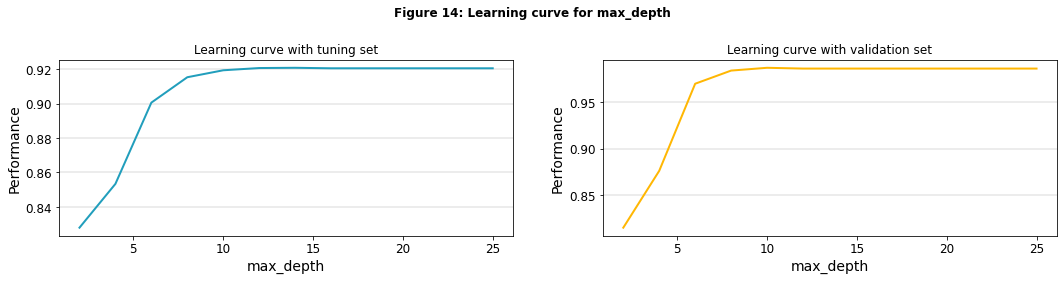

In [76]:
## Visualisation of learning rate for both data set
table_param_4 = table_param(grid_4_tuning, grid_4_val, 'max_depth')
plot_learning(table_param_4, 'max_depth', 'Figure 14: Learning curve for max_depth')

Based on the parameters previously selected, we observe that the elbow of both performance curves is around 8. We will therefore stick to 8 as a maximum depth value for the trees, and not go any further to limit the risk of overfitting.

### 7.2.5 'min_samples_split'

This parameters tells the decision tree in a random forest the minimum required number of observations in any given node in order to split it. As the default value is 2, which may lead the trees to keep growing until nodes are completely pure, it is sound to try to increase the value of this parameter without loosing too much performance (Saxena 2020).

In [77]:
## Fifth round of fine-tuning - min_samples_split

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [50],            #||
     'max_leaf_nodes': [35],          #|Selected results from previous round
     'criterion': ['entropy'],        #||
     'max_depth':[8],                 #||
    
     'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 20, 24] } # Main criteria to test for the fifth round
  ]

extra3_clf_grid = ExtraTreesClassifier(random_state = seed_value)

grid_search_r5 = GridSearchCV(extra3_clf_grid, param_grid, cv= 10,
                              scoring= scoring_var,
                              return_train_score=True,
                              refit = 'Recall')

grid_search_r5_tuning = grid_search_r5.fit(x_tuning, y_tuning)

In [78]:
## Results of fifth grid search with tuning set - min_samples_split
grid_5_tuning = grid_results(grid_search_r5_tuning)
highlight_best(grid_5_tuning)

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.055607,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 2, 'n_estimators': 50}",0.880374,0.966701,0.840802,0.910948
1,0.045210,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 4, 'n_estimators': 50}",0.877387,0.964200,0.838327,0.908206
2,0.045995,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 6, 'n_estimators': 50}",0.876464,0.962125,0.838391,0.906921
3,0.045652,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 8, 'n_estimators': 50}",0.870715,0.960040,0.831992,0.902572
4,0.044510,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 10, 'n_estimators': 50}",0.872786,0.956297,0.836929,0.902605
5,0.049683,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 12, 'n_estimators': 50}",0.867034,0.952554,0.831495,0.897688
6,0.045737,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 14, 'n_estimators': 50}",0.867958,0.953385,0.832253,0.898558
7,0.059761,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 16, 'n_estimators': 50}",0.863121,0.952137,0.826690,0.895084
8,0.051501,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 20, 'n_estimators': 50}",0.858753,0.947559,0.823561,0.890756
9,0.042641,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 24, 'n_estimators': 50}",0.852541,0.945057,0.816975,0.885991


In [79]:
## Fifth round of fine-tuning with validation set - min_samples_split
grid_search_5_val = grid_search_r5.fit(x_val, y_val)

In [80]:
## Results of fifth grid search with validation set - min_samples_split
grid_5_val = grid_results(grid_search_5_val)
highlight_best(grid_5_val)

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.045383,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 2, 'n_estimators': 50}",0.978606,0.988765,0.973049,0.982114
1,0.046205,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 4, 'n_estimators': 50}",0.977917,0.987515,0.973061,0.981271
2,0.045370,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 6, 'n_estimators': 50}",0.968252,0.981281,0.962175,0.972856
3,0.044311,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 8, 'n_estimators': 50}",0.951686,0.962562,0.950859,0.955954
4,0.053205,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 10, 'n_estimators': 50}",0.935125,0.945062,0.938297,0.939417
5,0.057139,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 12, 'n_estimators': 50}",0.924090,0.937577,0.926189,0.929695
6,0.044057,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 14, 'n_estimators': 50}",0.916494,0.927593,0.922029,0.921487
7,0.042018,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 16, 'n_estimators': 50}",0.901307,0.913873,0.908550,0.907058
8,0.042607,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 20, 'n_estimators': 50}",0.870244,0.872685,0.891015,0.873298
9,0.044065,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_split': 24, 'n_estimators': 50}",0.853003,0.846435,0.882924,0.853368


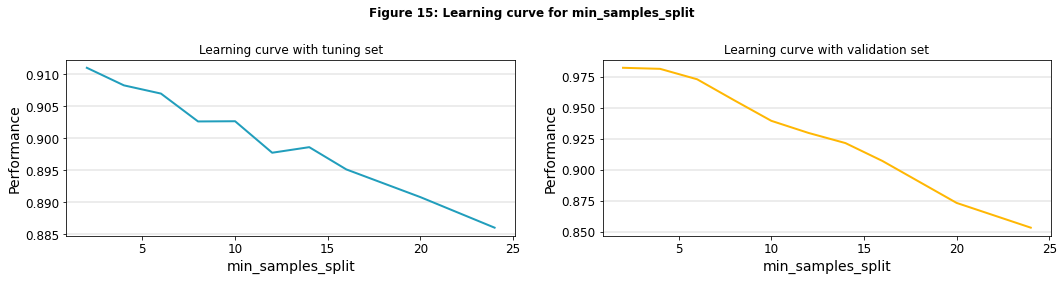

In [81]:
# Visualisation of learning rate for both data set
table_param_5 = table_param(grid_5_tuning, grid_5_val, 'min_samples_split')
plot_learning(table_param_5, 'min_samples_split', 'Figure 15: Learning curve for min_samples_split')

In order to limit the risk of overfitting, we take a value slighly higher than the best value of 2, for which the performance doesn't decrease to drastically. Therefore we pick a value of 6.

### 7.2.6 'min_samples_leaf'

This hyperparameters dictates for each leaf node after splitting a node, the minimum number of instances to be included within the leaf node (Saxena 2020). This is yet another parameter to limit the growth of the trees and the risk of overfitting.

In [82]:
## Sixth round of fine-tuning - min_samples_leaf

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [50],            #||
     'max_leaf_nodes': [35],          #||
     'criterion': ['entropy'],        #|Selected results from previous round
     'max_depth':[8],                 #||
     'min_samples_split': [6],        #||
     
     'min_samples_leaf': [1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 40, 60, 100]} # Main criteria to test for the sixth round
  ]

extra3_clf_grid = ExtraTreesClassifier(random_state = seed_value)

grid_search_r6 = GridSearchCV(extra3_clf_grid, param_grid, cv= 10,
                              scoring= scoring_var,
                              return_train_score=True,
                              refit = 'Recall')

grid_search_r6_tuning = grid_search_r6.fit(x_tuning, y_tuning)

In [83]:
## Results of sixth grid search with tuning set - min_samples_leaf
grid_6_tuning = grid_results(grid_search_r6_tuning)
highlight_best(grid_6_tuning)

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.055528,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 50}",0.876464,0.962125,0.838391,0.906921
1,0.056881,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 50}",0.868413,0.956719,0.830922,0.899986
2,0.046294,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.861974,0.950894,0.825842,0.893929
3,0.044882,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 50}",0.853921,0.944231,0.819156,0.886569
4,0.045637,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 50}",0.835517,0.930085,0.803413,0.870134
5,0.045420,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 50}",0.827694,0.919685,0.799074,0.861629
6,0.043977,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 50}",0.821253,0.913017,0.794387,0.855272
7,0.043878,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 50}",0.813432,0.903859,0.789261,0.847186
8,0.043382,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 14, 'min_samples_split': 6, 'n_estimators': 50}",0.815733,0.905944,0.791072,0.849351
9,0.043766,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 16, 'min_samples_split': 6, 'n_estimators': 50}",0.812283,0.902206,0.788693,0.845893


In [84]:
## Sixth round of fine-tuning with validation set - min_samples_leaf
grid_search_6_val = grid_search_r6.fit(x_val, y_val)

In [85]:
## Results of sixth grid search with validation set - min_samples_leaf
grid_6_val = grid_results(grid_search_6_val)
highlight_best(grid_6_val)

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.042937,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 50}",0.968252,0.981281,0.962175,0.972856
1,0.040113,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 50}",0.949626,0.961296,0.948471,0.954179
2,0.042940,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.892328,0.901373,0.903839,0.897097
3,0.040235,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 50}",0.851614,0.870185,0.862652,0.860146
4,0.043243,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 50}",0.830924,0.843966,0.849391,0.837988
5,0.041714,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 50}",0.819186,0.833951,0.838272,0.827000
6,0.041461,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 50}",0.812289,0.820216,0.837089,0.817940
7,0.045036,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 50}",0.803999,0.812747,0.829638,0.810062
8,0.043191,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 14, 'min_samples_split': 6, 'n_estimators': 50}",0.799171,0.817747,0.818950,0.808580
9,0.040375,"{'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 16, 'min_samples_split': 6, 'n_estimators': 50}",0.794344,0.821481,0.809489,0.806713


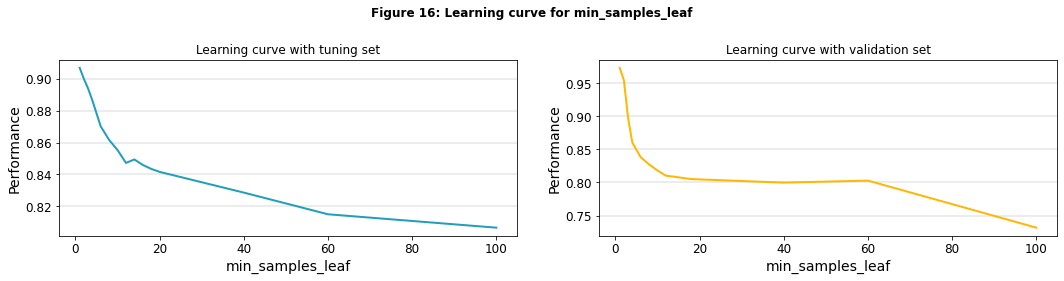

In [86]:
# Visualisation of learning rate for both data set
table_param_6 = table_param(grid_6_tuning, grid_6_val, 'min_samples_leaf')
plot_learning(table_param_6, 'min_samples_leaf', 'Figure 16: Learning curve for min_samples_leaf')

We see that the performance decrease quite sharply after a value of 2 for our validation set. We therefore try to continue with a value of 3 for the rest of the process.

### 7.2.7 'max_features'

This parameters modifies the number of features to consider when looking for the best split.

In [87]:
## Seventh round of fine-tuning - max_features

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [50],            #||
     'max_leaf_nodes': [35],          #||
     'criterion': ['entropy'],        #|Selected results from previous round
     'max_depth':[8],                 #||
     'min_samples_split': [6],        #||
     'min_samples_leaf': [3],         #||
     
     'max_features': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]} # Main criteria to test for the seventh round
  ]

extra3_clf_grid = ExtraTreesClassifier(random_state = seed_value)

grid_search_r7 = GridSearchCV(extra3_clf_grid, param_grid, cv= 10,
                              scoring= scoring_var,
                              return_train_score=True,
                              refit = 'Recall')

grid_search_r7_tuning = grid_search_r7.fit(x_tuning, y_tuning)

In [88]:
## Results of seventh grid search with tuning set - max_features
grid_7_tuning = grid_results(grid_search_r7_tuning)
highlight_best(grid_7_tuning)

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.042019,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 1, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.838507,0.921336,0.811948,0.868983
1,0.044409,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 2, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.845869,0.936738,0.812959,0.878926
2,0.048636,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 4, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.861974,0.950894,0.825842,0.893929
3,0.050017,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 6, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.873706,0.960043,0.835997,0.904470
4,0.049655,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.874395,0.960047,0.836812,0.904898
5,0.050808,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 10, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.879458,0.962541,0.842062,0.908952
6,0.051966,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 12, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.881067,0.965038,0.842703,0.910819
7,0.054849,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 14, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.888426,0.968783,0.850299,0.916756
8,0.061582,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 16, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.888889,0.966290,0.852500,0.916211
9,0.060033,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 18, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.896021,0.970035,0.859910,0.922015


In [89]:
## Seventh round of fine-tuning with validation set - max_features
grid_search_7_val = grid_search_r7.fit(x_val, y_val)

In [90]:
## Results of seventh grid search with validation set - max_features
grid_7_val = grid_results(grid_search_7_val)
highlight_best(grid_7_val)

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.038898,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 1, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.855072,0.866420,0.870877,0.861192
1,0.038625,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 2, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.860603,0.872654,0.875157,0.866879
2,0.038015,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 4, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.892328,0.901373,0.903839,0.897097
3,0.042476,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 6, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.922021,0.926358,0.932234,0.924777
4,0.041355,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 8, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.950991,0.966281,0.946340,0.956642
5,0.042011,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 10, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.947548,0.958796,0.947175,0.952010
6,0.041850,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 12, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.953764,0.965031,0.952283,0.958123
7,0.042151,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 14, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.960666,0.971265,0.958201,0.964659
8,0.044654,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 16, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.952375,0.961281,0.953158,0.956016
9,0.048721,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 18, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.954444,0.962531,0.955461,0.957781


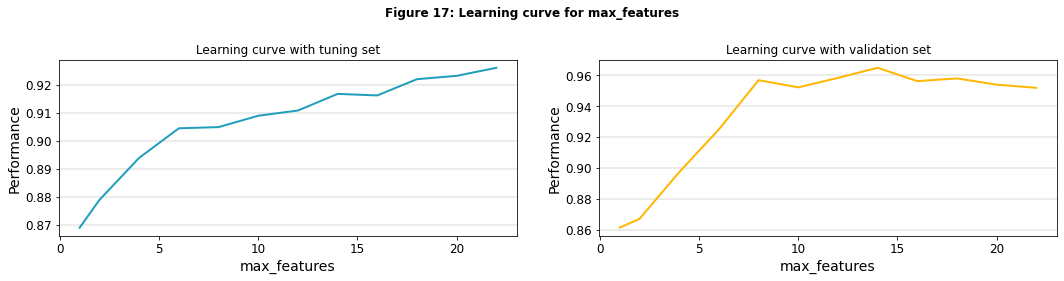

In [91]:
# Visualisation of learning rate for both data set
table_param_7 = table_param(grid_7_tuning, grid_7_val, 'max_features')
plot_learning(table_param_7, 'max_features', 'Figure 17: Learning curve for max_features')

Here the performance appears to keep on increasing for the tuning set, whereas it starts decreasing after 14 for the validation set. Therefore we set the value at 14 for the next iterations.

### 7.2.8 'bootstrap samples'

This parameter enables to choose whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

In [92]:
## Eighth round of fine-tuning - bootstrap samples

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [50],            #||
     'max_leaf_nodes': [35],          #||
     'criterion': ['entropy'],        #||
     'max_depth':[8],                 #|Selected results from previous round
     'min_samples_split': [6],        #||
     'min_samples_leaf': [3],         #||
     'max_features': [14],            #|| 
     
     'bootstrap': ['True', 'False']} # Main criteria to test for the eight round
  ]

extra3_clf_grid = ExtraTreesClassifier(random_state = seed_value)

grid_search_r8 = GridSearchCV(extra3_clf_grid, param_grid, cv= 10,
                              scoring= scoring_var,
                              return_train_score=True,
                              refit = 'Recall')

grid_search_r8_tuning = grid_search_r8.fit(x_tuning, y_tuning)

In [93]:
## Results of eight grid search with tuning set - bootstrap
grid_8_tuning = grid_results(grid_search_r8_tuning)
highlight_best(grid_8_tuning)

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.064138,"{'bootstrap': 'True', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 14, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.882679,0.961295,0.847194,0.910577
1,0.064480,"{'bootstrap': 'False', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 14, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.882679,0.961295,0.847194,0.910577


In [94]:
## Eight round of fine-tuning with validation set - bootstrap
grid_search_8_val = grid_search_r8.fit(x_val, y_val)

In [95]:
## Results of eight grid search with validation set - bootstrap
grid_8_val = grid_results(grid_search_8_val)
highlight_best(grid_8_val)

,mean_fit_time,params,mean_train_Accuracy,mean_train_Recall,mean_train_Precision,Perf_metric
0,0.053717,"{'bootstrap': 'True', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 14, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.904066,0.918873,0.909040,0.910486
1,0.056166,"{'bootstrap': 'False', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 14, 'max_leaf_nodes': 35, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}",0.904066,0.918873,0.909040,0.910486


As the 'bootstrap' hyperparameter has no impact on the model performance, we do not need to test for the next hyperparameters related to the bootstrap (max number of samples), and stop our fine tuning at this stage.

### 7.2.9 Final model set-up

In [96]:
## tenth round of fine-tuning - final selection

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [50],            #||
     'max_leaf_nodes': [35],          #||
     'criterion': ['entropy'],        #||
     'max_depth':[8],                 #||
     'min_samples_split': [6],        #|FINAL SELECTION
     'min_samples_leaf': [3],         #||
     'max_features': [14],            #|| 
     'bootstrap': ['False']}          #||

  ]

extra3_clf_grid = ExtraTreesClassifier(random_state = seed_value)

grid_search_r10 = GridSearchCV(extra3_clf_grid, param_grid, cv= 10,
                              scoring= scoring_var,
                              return_train_score=True,
                              refit = 'Recall')

grid_search_r10.fit(x_tuning, y_tuning)

GridSearchCV(cv=10, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,...
             iid='deprecated', n_jobs=None,
             param_grid=[{'bootstrap': ['False'], 'criterion': ['entropy'],
                          'max_depth': [8], 'max_features

In [97]:
grid_search_r10.best_estimator_

ExtraTreesClassifier(bootstrap='False', ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=8, max_features=14,
                     max_leaf_nodes=35, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=3, min_samples_split=6,
                     min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

## Evaluation of the final model

We now perform the evaluation of the fine-tuned model on our full training set and test set.

In [98]:
## Set-up the testing data

test = test_set.drop("label", axis=1)
test_label = test_set["label"].copy()

# Apply pre-processing function on our training data set
test_data = pre_process(test, categorical_var[:-1], numerical_var)

x_test = test_data
y_test = test_label

Text(0.5, 1.0, 'Figure 18: Confusion matrix on training set')

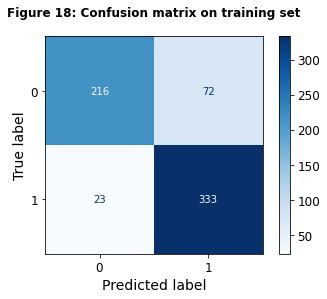

In [99]:
## Set the trained-model with the best parameters defined earlier
trained_model = grid_search_r10.best_estimator_

## Confusion matrix on entire training set
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(trained_model, x_train, y_train, cmap = 'Blues', values_format = '')
plt.title('Figure 18: Confusion matrix on training set', {'fontsize': 12}, fontweight = 'bold', pad = 20)

In [100]:
## Recall value on the training set
trained_predictions = trained_model.predict(x_train)
recall_val_train = recall_score(y_train, trained_predictions)
recall_val_train

0.9353932584269663

In [101]:
## Accuracy on current model
from sklearn.metrics import accuracy_score
accuracy_val_train = accuracy_score(y_train, trained_predictions)
accuracy_val_train

0.8524844720496895

Text(0.5, 1.0, 'Figure 19: Confusion matrix on test set')

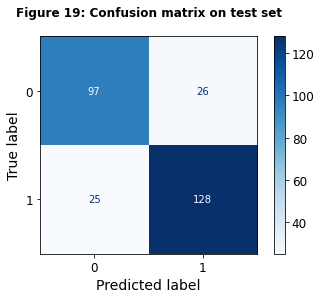

In [102]:
plot_confusion_matrix(trained_model, x_test, y_test, cmap = 'Blues', values_format = '')
plt.title('Figure 19: Confusion matrix on test set', {'fontsize': 12}, fontweight = 'bold', pad = 20)

In [103]:
test_predictions = trained_model.predict(x_test)
recall_val_test = recall_score(y_test, test_predictions)
recall_val_test

0.8366013071895425

In [104]:
accuracy_val_test = accuracy_score(y_test, test_predictions)
accuracy_val_test

0.8152173913043478

We observe that the performance metrics for our model on the test set are quite significantly worse than when assessed on our training set. We can therefore say that our model is overfitting.

# 8. Conclusion

In this paper we tried to re-produce the findings of the related litterature regarding the prediction of heart-disease based on diagnosis data on an extended set of data, and optimize for our own performance metric with a focus on recall.

We selected an Extremely Randomized Trees ensemble method, and obtained after hyperparameters tuning a recall score of 0.94 for our training set and of 0.84 for our test set, as well as an accuracy score of 0.85 for our training set, and of 0.82 for our testing set.

Based on these results, we conclude that our current model is overfitting, which can be due to several reasons. First the quality of our data could be improved, as several features have a significant amount of missing data, and may have led to additional noise in our data set. This might also be an explanation as to why most of the litterature focuses only the Cleveland dataset. Secondly the fine tuning of our model could be improved, and the values set to limit the growth of our tree may have been set to values that are too low, therefore leading the trees to overfit.

We would suggest to first investigate further techniques such a Random Search or Bayesian optimization to fine-tune our model with more success, and then potentially investigate more complicated models based on artificial neural networks that have demonstrated much better performance according to the existing litterature.

# 9. References

(1) Tougui, I., Jilbab, A. and El Mhamdi, J. (2020) ‘Heart disease classification using data mining tools and machine learning techniques’, Health and Technology, 10(5), pp. 1137–1144. doi: 10.1007/s12553-020-00438-1.

(2) Rani, P. et al. (2021) ‘A decision support system for heart disease prediction based upon machine learning’, Journal of Reliable Intelligent Environments, (0123456789). doi: 10.1007/s40860-021-00133-6.

(3) Sabay, A. et al. (2018) ‘Overcoming Small Data Limitations in Heart Disease Prediction by Using Surrogate Data’, SMU Data Science Review, 1(3), p. 12. Available at: https://scholar.smu.edu/datasciencereviewhttp://digitalrepository.smu.edu.Availableat:https://scholar.smu.edu/datasciencereview/vol1

(4) Budholiya, K., Shrivastava, S. K. and Sharma, V. (2020) ‘An optimized XGBoost based diagnostic system for effective prediction of heart disease’, Journal of King Saud University - Computer and Information Sciences, (xxxx). doi: 10.1016/j.jksuci.2020.10.013./iss3/12.

(5) Gárate-Escamila, A. K., Hajjam El Hassani, A. and Andrès, E. (2020) ‘Classification models for heart disease prediction using feature selection and PCA’, Informatics in Medicine Unlocked, 19. doi: 10.1016/j.imu.2020.100330.

(6) Cay, S. et al. (2009) ‘Association of heart rate profile during exercise with the severity of coronary artery disease’, Journal of Cardiovascular Medicine, 10(5). doi: 10.2459/JCM.0b013e328329c715.

(7) Van Rijn, J. N. and Hutter, F. (2017) ‘An empirical study of hyperparameter importance across datasets’, CEUR Workshop Proceedings, 1998.

(8) Probst, P., Wright, M. N. and Boulesteix, A. L. (2019) ‘Hyperparameters and tuning strategies for random forest’, Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery. doi: 10.1002/widm.1301.

(9) Geurts, P., Ernst, D. and Wehenkel, L. (2006) ‘Extremely randomized trees’, Machine Learning, 63(1), pp. 3–42. doi: 10.1007/s10994-006-6226-1.

(10) Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition, by Aurélien Géron (O’Reilly). Copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9.

(11) Archive.ics.uci.edu. 2021. UCI Machine Learning Repository: Heart Disease Data Set. [online] Available at: <https://archive.ics.uci.edu/ml/datasets/Heart+Disease> [Accessed 7 March 2021].

(12) Who.int. 2020. The top 10 causes of death. [online] Available at: <https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death> [Accessed 7 March 2021].

(13) Scikit-learn.org. 2020. 10. Common pitfalls and recommended practices — scikit-learn 0.24.1 documentation. [online] Available at: <https://scikit-learn.org/stable/common_pitfalls.html#randomness> [Accessed 7 March 2021].

(14) En.wikipedia.org. 2021. ST segment. [online] Available at: <https://en.wikipedia.org/wiki/ST_segment> [Accessed 7 March 2021].

(15) Harvard Health Publishing., 2017. The danger of “silent” heart attacks - Harvard Health. [online] Harvard Health. Available at: <https://www.health.harvard.edu/heart-health/the-danger-of-silent-heart-attacks> [Accessed 7 March 2021].
Kashou, A., Basit, H. and Malik, A., 2020. ST Segment. [online] Ncbi.nlm.nih.gov. Available at: <https://www.ncbi.nlm.nih.gov/books/NBK459364/> [Accessed 7 March 2021].

(16) Johns Hopkins Medicine, 2021. Exercise Electrocardiogram. [online] Available at: <https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/exercise-electrocardiogram> [Accessed 7 March 2021].

(17) Saxena, S. 2020. Random Forest Hyperparameter Tuning in Python | Machine learning. [online] Analytics Vidhya. Available at: <https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/> [Accessed 7 March 2021].

# 10. Appendix

Appendix 1: Features name and description

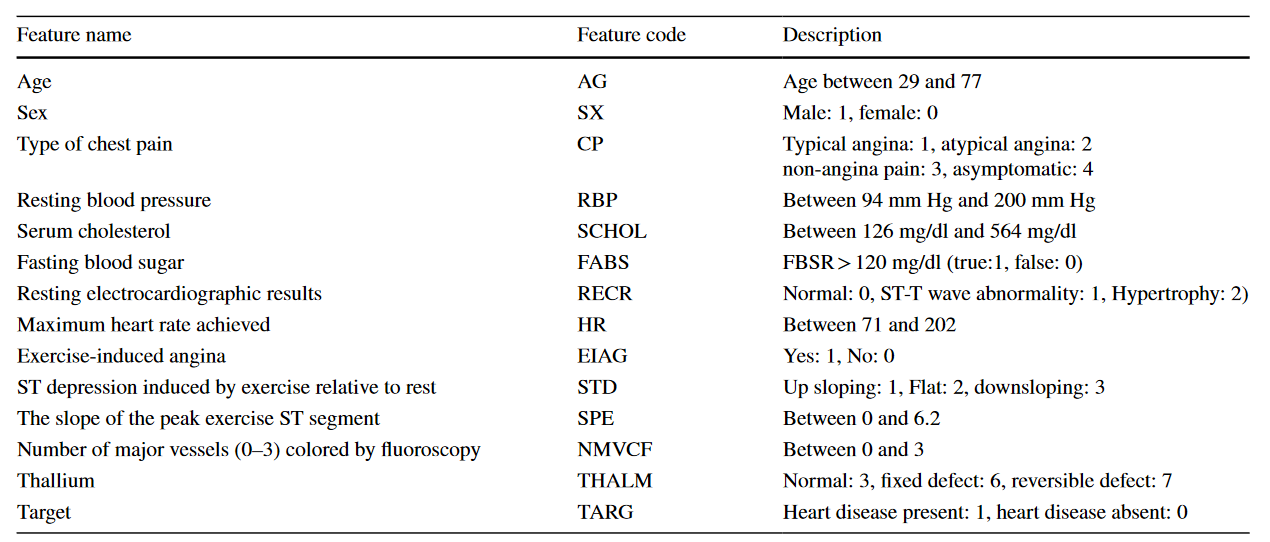

In [107]:
from IPython.display import Image
Image(filename='Features_description.png') 

Appendix 2: Schematic representation of normal ECG

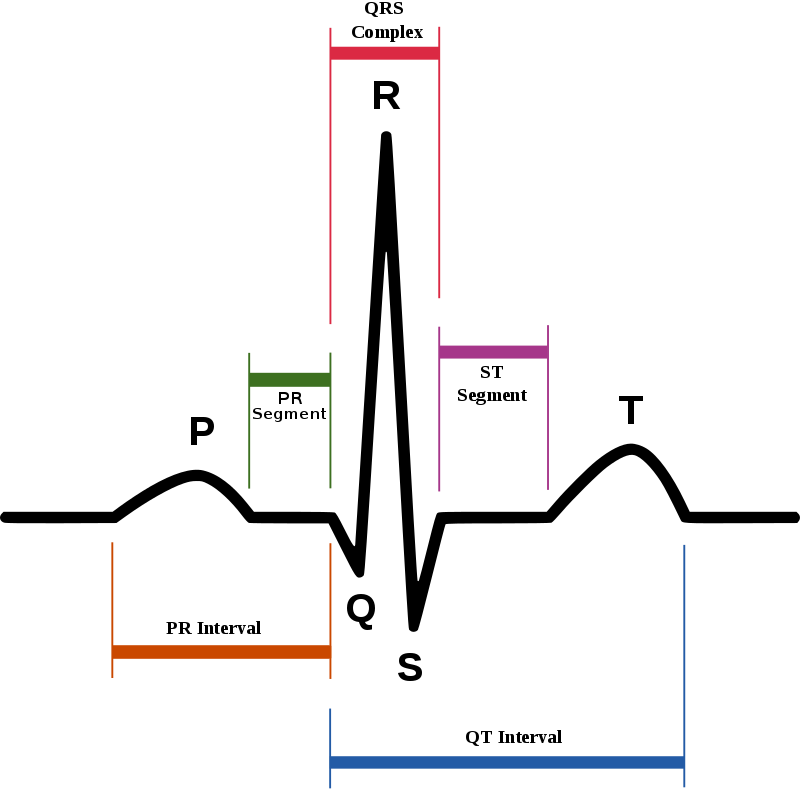

In [110]:
from IPython.display import Image
Image(filename='ST_segment.png', width = 400) 